# Seasonal dust trends in Northern Utah
## MATH 4100 - Final Project



### Christopher Rapp
christopher.rapp@utah.edu
u0980933

### Parth Rastogi
parth.rastogi@utah.edu
u1119560

**SECTION:** IMPORT LIBRARIES

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import seaborn as sns
from windrose import WindroseAxes

**READ ME:** For the windrose plots, you will need to install the following package

In [2]:
#pip install windrose

In [3]:
# Get working directory
cwd = os.getcwd()

# Directory names
directories = ['/hourly_pm25_UDAQ', '/epa_PM25', '/epa_PM10', '/MESOWEST']

## Introduction

Air pollution is not an uncommon occurrence for many Utah residents. The Salt Lake Valley is notorious for poor air quality during winter months. Particulate matter such as PM2.5 (particulate matter that is 2.5 microns or smaller)  is abundant during persistent cold air pool events, more commonly referred to as simply “inversions”, where a strong temperature inversion prevents pollutants from mixing upwards. However, air pollution isn’t exclusive to the winter months. Northern Utah frequently experiences poor air quality during the summer months as well due to wildfire smoke. In fact, Salt Lake City was ranked as having the 5th worst air quality in the world the morning of September 7, 2020 according to IQAir (Gardiner, J., 2020).

Another particulate pollutant that impacts Utah is dust. “Mineral aerosols or desert dust particles are soil particles suspended in the atmosphere in regions with easily erodible dry soils, little vegetation and strong winds” (Mahowald et. al., 2015). Dust are aerosols that typically fall into the coarse mode which ranges in size from 1000 nm to 10000 nm. Due to this size range, measurements of dust involve sensors or filters suited for PM10 (aerosols 10 microns in diameter or smaller).

Dust is harmful to human health, but the climatic effects it signals are more severe. Drought, soil erosion, and water diversion all increase the amount of potential aerosol that can be lifted off the ground during strong wind conditions such as frontal passages. Additionally, studies have shown that the presence of dust and black carbon accelerate snowmelt and deplete water reserves built during the winter (Skiles et. al., 2012). This study was conducted for the Colorado River Basin, but similar patterns are seen along the Wasatch Front. Recent work has shown that the chemical composition of dust found along the Wasatch Front reflects regional playa dust as found near the Great Salt Lake (Goodman et. al., 2019). As water management in Utah is heavily dependent on snowpack, potential increases in dust are alarming. 

The objective of our project is to study how wind across the Great Salt Lake and Great Basin affect aerosol concentrations in the Salt Lake Valley, and to identify potential seasonal trends in dust. We plan to accomplish this by studying how PM2.5 and PM10 concentrations at a variety of sites throughout the Salt Lake Valley change during high wind events.

Poor air quality is not related to dust alone. A major source of air pollution throughout the intermountain west has been wildfire smoke particularly during late summer months when wildfire season peaks. To better distinguish between these types of pollution we would need to heavily rely on cross-referencing our data with wildfire data. This would greatly be beyond the scope of this project, however when we analyze seasonal trends it becomes more interesting to see if we can identify dust events using wind alone. Additionally, to classify differences between wildfire smoke and dust would require the use of satellite observations such as aerosol optical depth (AOD) and Ångström exponent, which would also be beyond the scope of this project.

Our overall research question is to identify if there is a statistically significant correlation between high wind speeds originating from the Great Salt Lake/Great Basin and spikes in particulate matter throughout the Salt Lake Valley. If we can provide some evidence to support that using a primitive approach with wind data as this project does, then it strengthens a theory worrying researchers in Utah: a drying lake bed increasing the prevalence of dust.

This notebook is divided into the following sections that follow the Data Science Process:

* Data Acquisition
* Data Wrangling
* Exploratory Data Analysis
* Seasonal Wind and Pollution Analysis
    * Correlation Plots and Spearman Correlations
    * Hypothesis Testing
* Visualization
    * Wind Roses by Site
    * Geospatial Wind Roses??????




## Data Acquisition

### Utah Department of Air Quality
http://airmonitoring.utah.gov/dataarchive/archpm25.htm

From this source, we were looking to extract hourly particulate matter concentrations for sites within the Salt Lake Valley. After further inspection, only hourly PM2.5 data was available. We downloaded each year’s worth of hourly data for all sites within Utah as this was the easiest option. Each file was in the .csv format. We performed basic renaming to specify the year for each. Additionally we removed the numeric additions to filenames for each consecutive download to a local computer.

### EPA Daily Data
https://www.epa.gov/outdoor-air-quality-data/download-daily-data

From this source, we had to select data per year and for all sites in Utah for each particulate matter size. It was time consuming but very easy. Similarly to above, each file was in the .csv format and we performed basic renaming for each to distinguish which year the data belonged to, and the particle size.


### MESOWEST/Synoptic Data API
https://download.synopticdata.com

The atmospheric data we’re interested in was accessed using Synoptic Data API Services. While the actual downloading process was fairly straightforward, the data cleaning process required more work (as mentioned below). We set a threshold to obtain data sets spanning years 2000 to 2020. If data sets only had data from 2015 to 2020 we excluded those and chose others. The sites we acquired data for included:

#### Salt Lake Valley Sites (5)

* KU42 - Salt Lake City MUN - NWS(network)
* KSLC - Salt Lake City Int - NWS(network)
* DW6558 Magna - D6558 - APRSWXNET/CWOP(network)

* CW8880 Riverton - C8880 - APRSWXNET/CWOP(network)

* DW6120 - Sandy (Replacing FW6180 South Salt)

#### Northwest Utah Sites (15)

* Bolinder Field - KTVY - NWS(network)
* Wendover/Air For - KENV - NWS(network)
* Ogden-Hinckley Air -  KOGD - NWS(network)
* Brigham City Regional Airport - KBMC - NWS(network)
* Rosebud - RSBU1 - RAWS(network)
* Aragonite - ARAU1 - RAWS(network)
* CW8846 Park Valley - C8846 - APRSWXNET/CWOP(network)
* CW8845 Snowville 1 - C8845 - APRSWXNET/CWOP(network)
* KF6RAL -6 Great Sal - AS768 - APRSWXNET/CWOP(network)
* Lakeside Mountain - LMR 
* Gunnison Island - GNI 
* Locomotive Springs - LMS
* Snowville (West) - UCC01
* Hat Island - HATUT
* Lake Point I-80 (Replacing I-80 at MP71 East - UTEDL)

For each site we selected the following required variables: wind speed, wind gust, and wind direction (deg), wind direction (cardinal). We also selected the optional variables: altimeter, pressure, and temperature.

## Data Wrangling

For each directory of data we use a method of looping through the file names, generating a dataframe for each file, then append to a dataframe with an empty column 'Date'. The code is well commented with section headers for each dataset.

Values of the stations in Site ID for the particulate matter datasets are the following:
* UT is 490353015.0 - Utah Air
* HW is 490353006.0 - Hawthorne
* RP is 490353010.0 - Rose Park
* CV is 490352005.0 - Copper View
* NR is 490354002.0 - Near Road Murray
* LP is 490353014.0 - Lake View

**SECTION:** HOURLY PM2.5 DATA - File Paths

In [4]:
# Set this directory as the path we are using to loop through CSV files
path = cwd + directories[0]

# Files
files = os.listdir(path)

# Sort in ascending order
files.sort()

# Initialize a dictionary object
paths = []
names = []
for i in (range(0, len(files), 1)):
    
    # Path
    tmp_path = cwd + directories[0] + '/' + files[i]
    paths.append(tmp_path)
    
    # Retreive names
    tmp_names = files[i][:len(files[i])-4].replace('.', '')
    names.append(tmp_names)


**SECTION:** HOURLY PM2.5 DATA - Dataframe and Cleaning

In [5]:
# Initialize dictionary
D = {}

# Initialize dateframe with common column Date
df = pd.DataFrame(columns = ['Date'])
for i in (range(0, len(names), 1)):
    # Create a dataframe for each file and renaming the date column
    D[names[i]] = pd.read_csv(paths[i]).rename(columns = {'Unnamed: 0':'Date'})

    # Appending to the empty dataframe
    df = df.append(D[names[i]])
    
# Drops the first two rows of bad headers
df = df.drop(df.index[[0,1]])

# Create a datetime object
df['Datetime'] = pd.to_datetime(df['Date'])

# Subset
hourly_PM25 = df[['Datetime', 'HW', 'RP', 'LP', 'UT', 'NR', 'CV']].copy(deep = True)

# Remove empty datetime rows
hourly_PM25 = hourly_PM25.dropna(subset = ['Datetime'], how = "any")

# Convert data types and create time series
hourly_PM25 = hourly_PM25.set_index('Datetime').astype(float)

# Drop rows of empty data
hourly_PM25 = hourly_PM25.dropna(subset = ['HW', 'RP', 'LP', 'UT', 'NR', 'CV'], how = "all")

# Rename columns with site names in addition to ID's so they are easier to distinguish
hourly_PM25 = hourly_PM25.rename(columns = {'HW':'HW - Hawthorne',
                                            'RP':'RP - Rose Park',
                                            'LP':'LP - Lake View',
                                            'UT':'UT - Utah Air',
                                            'NR':'NP - Near Road Murry',
                                            'CV':'CV - Copper View'})

hourly_PM25['Average PM2.5'] = hourly_PM25.iloc[:,0:5].mean(axis=1)

# Display dataframe
hourly_PM25

HW - Hawthorne  RP - Rose Park  LP - Lake View  \
Datetime                                                              
2003-12-02 15:00:00            46.6             NaN             NaN   
2003-12-02 16:00:00            13.0             NaN             NaN   
2003-12-02 17:00:00            40.2             NaN             NaN   
2003-12-02 18:00:00            50.6             NaN             NaN   
2003-12-02 19:00:00            39.8             NaN             NaN   
...                             ...             ...             ...   
2020-12-31 19:00:00            14.6            13.3            17.7   
2020-12-31 20:00:00            13.0            13.7            18.5   
2020-12-31 21:00:00            11.9            16.6            17.1   
2020-12-31 22:00:00            16.2            14.2            17.5   
2020-12-31 23:00:00            14.2            18.7            16.9   

                     UT - Utah Air  NP - Near Road Murry  CV - Copper View  \
Datetime                                                                     
2003-12-02 15:00:00            NaN                   NaN               NaN   
2003-12-02 16:00:00            NaN                   NaN               NaN   
2003-12-02 17:00:00            NaN                   NaN               NaN   
2003-12-02 18:00:00            NaN                   NaN               NaN   
2003-12-02 19:00:00            NaN                   NaN               NaN   
...                            ...                   ...               ...   
2020-12-31 19:00:00            8.3                  17.1              18.9   
2020-12-31 20:00:00            9.3                  17.1              20.3   
2020-12-31 21:00:00            7.3                  14.6              19.3   
2020-12-31 22:00:00            8.9                  17.2              18.0   
2020-12-31 23:00:00            9.3                  18.8              19.2   

                     Average PM2.5  
Datetime                            
2003-12-02 15:00:00          46.60  
2003-12-02 16:00:00          13.00  
2003-12-02 17:00:00          40.20  
2003-12-02 18:00:00          50.60  
2003-12-02 19:00:00          39.80  
...                            ...  
2020-12-31 19:00:00          14.20  
2020-12-31 20:00:00          14.32  
2020-12-31 21:00:00          13.50  
2020-12-31 22:00:00          14.80  
2020-12-31 23:00:00          15.58  

[129356 rows x 7 columns]

**SECTION:** EPA PM2.5 DATA - File Paths

In [6]:
# Set this directory as the path we are using to loop through CSV files
path = cwd + directories[1]

# Files
files = os.listdir(path)

# Sort in ascending order
files.sort()

# Initialize a dictionary object
paths = []
names = []
for i in (range(0, len(files), 1)):
    
    # Path
    tmp_path = cwd + directories[1] + '/' + files[i]
    paths.append(tmp_path)
    
    # Retreive names
    tmp_names = files[i][:len(files[i])-4].replace('.', '')
    names.append(tmp_names)


**SECTION:** EPA PM2.5 DATA - Dataframe and Cleaning

In [7]:
# Initialize dictionary
D = {}

# Initialize dateframe with common column Date
df = pd.DataFrame(columns = ['Date'])
for i in (range(0, len(names), 1)):
    # Create a dataframe for each file and renaming the date column
    D[names[i]] = pd.read_csv(paths[i])

    # Appending to the empty dataframe
    df = df.append(D[names[i]])
    
#Create datetime object    
df['Datetime'] = pd.to_datetime(df['Date'])

#Subset
PM25 = df[['Datetime', 'Site ID', 'POC', 'Daily Mean PM2.5 Concentration', 'DAILY_AQI_VALUE', 'Site Name','CBSA_NAME','SITE_LATITUDE', 'SITE_LONGITUDE']].copy(deep = True)

# Remove empty datetime rows
PM25 = PM25.dropna(subset = ['Datetime'], how = "any")

# Removing rows that are not the sites we need
PM25 = PM25.loc[df['Site ID'].isin(['490353015.0','490353006.0','490353010.0','490352005.0','490354002.0','490353014.0'])]

# Replace numeric site ID with the station named ID's to match hourly UDAQ ID's
PM25 = PM25.replace([490353015.0, 490353006.0, 490353010.0, 490352005.0, 490354002.0, 490353014.0],['UT','HW','RP','CV','NR','LP'])
PM25

Datetime Site ID  POC  Daily Mean PM2.5 Concentration  DAILY_AQI_VALUE  \
613  2000-01-01      HW  1.0                            63.6            155.0   
614  2000-01-02      HW  1.0                            18.3             64.0   
615  2000-01-03      HW  1.0                            10.0             42.0   
616  2000-01-04      HW  1.0                            14.7             56.0   
617  2000-01-05      HW  1.0                             9.2             38.0   
...         ...     ...  ...                             ...              ...   
7377 2020-12-27      NR  1.0                            11.7             49.0   
7378 2020-12-28      NR  1.0                             9.6             40.0   
7379 2020-12-29      NR  1.0                            11.0             46.0   
7380 2020-12-30      NR  1.0                            16.7             61.0   
7381 2020-12-31      NR  1.0                            16.4             60.0   

      Site Name           CBSA_NAME  SITE_LATITUDE  SITE_LONGITUDE  
613   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
614   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
615   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
616   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
617   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
...         ...                 ...            ...             ...  
7377        NaN  Salt Lake City, UT      40.662878     -111.901188  
7378        NaN  Salt Lake City, UT      40.662878     -111.901188  
7379        NaN  Salt Lake City, UT      40.662878     -111.901188  
7380        NaN  Salt Lake City, UT      40.662878     -111.901188  
7381        NaN  Salt Lake City, UT      40.662878     -111.901188  

[26372 rows x 9 columns]

In [8]:
# Pivoting the dataframe by individual site and only daily PM10 values
# LP was not included in the EPA database for PM2.5 sites
PM25_pivot = PM25.pivot_table(index = 'Datetime', columns='Site ID', values='Daily Mean PM2.5 Concentration')
PM25_pivot

Site ID       CV         HW    NR         RP    UT
Datetime                                          
2000-01-01   NaN  63.600000   NaN        NaN   NaN
2000-01-02   NaN  18.300000   NaN        NaN   NaN
2000-01-03   NaN  10.000000   NaN        NaN   NaN
2000-01-04   NaN  14.700000   NaN        NaN   NaN
2000-01-05   NaN   9.200000   NaN        NaN   NaN
...          ...        ...   ...        ...   ...
2020-12-27  10.9  11.533333  11.7  11.166667  11.0
2020-12-28   8.4   4.033333   9.6   9.400000  11.0
2020-12-29   9.6   7.166667  11.0   9.500000  10.1
2020-12-30  14.4  10.433333  16.7  13.400000  13.8
2020-12-31  16.2  14.166667  16.4  14.933333  15.1

[7594 rows x 5 columns]

**SECTION:** EPA PM10 DATA - File Paths

In [9]:
# Set this directory as the path we are using to loop through CSV files
path = cwd + directories[2]

# Files
files = os.listdir(path)

# Sort in ascending order
files.sort()

# Initialize a dictionary object
paths = []
names = []
for i in (range(0, len(files), 1)):
    
    # Path
    tmp_path = cwd + directories[2] + '/' + files[i]
    paths.append(tmp_path)
    
    # Retreive names
    tmp_names = files[i][:len(files[i])-4].replace('.', '')
    names.append(tmp_names)


**SECTION:** EPA PM10 DATA - Dataframe and Cleaning

In [10]:
# Initialize dictionary
D = {}

# Initialize dateframe with common column Date
df = pd.DataFrame(columns = ['Date'])
for i in (range(0, len(names), 1)):
    # Create a dataframe for each file and renaming the date column
    D[names[i]] = pd.read_csv(paths[i])

    # Appending to the empty dataframe
    df = df.append(D[names[i]])
    
#Create datetime object    
df['Datetime'] = pd.to_datetime(df['Date'])

#Subset
PM10 = df[['Datetime', 'Site ID', 'POC', 'Daily Mean PM10 Concentration', 'DAILY_AQI_VALUE', 'Site Name','CBSA_NAME','SITE_LATITUDE', 'SITE_LONGITUDE']].copy(deep = True)

# Remove empty datetime rows
PM10 = PM10.dropna(subset = ['Datetime'], how = "any")

# Removing rows that are not the sites we need
PM10 = PM10.loc[df['Site ID'].isin(['490353015.0','490353006.0','490353010.0','490352005.0','490354002.0','490353014.0'])]

# Values of the stations in Site ID
# UT is 490353015.0
# HW is 490353006.0
# RP is 490353010.0
# CV is 490352005.0
# NR is 490354002.0
# LP is 490353014.0

# Replace numeric site ID with the station named ID's to match hourly UDAQ ID's
PM10 = PM10.replace([490353015.0, 490353006.0, 490353010.0, 490352005.0, 490354002.0, 490353014.0],['UT','HW','RP','CV','NR','LP'])
PM10


Datetime Site ID  POC  Daily Mean PM10 Concentration  DAILY_AQI_VALUE  \
781  2000-01-01      HW  1.0                           89.0             68.0   
782  2000-01-02      HW  1.0                           26.0             24.0   
783  2000-01-03      HW  1.0                           19.0             18.0   
784  2000-01-04      HW  1.0                           32.0             30.0   
785  2000-01-05      HW  1.0                           15.0             14.0   
...         ...     ...  ...                            ...              ...   
1512 2020-12-27      UT  1.0                           20.0             19.0   
1513 2020-12-28      UT  1.0                           26.0             24.0   
1514 2020-12-29      UT  1.0                           28.0             26.0   
1515 2020-12-30      UT  1.0                           32.0             30.0   
1516 2020-12-31      UT  1.0                           22.0             20.0   

      Site Name           CBSA_NAME  SITE_LATITUDE  SITE_LONGITUDE  
781   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
782   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
783   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
784   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
785   Hawthorne  Salt Lake City, UT      40.736389     -111.872222  
...         ...                 ...            ...             ...  
1512        NaN  Salt Lake City, UT      40.777145     -111.945849  
1513        NaN  Salt Lake City, UT      40.777145     -111.945849  
1514        NaN  Salt Lake City, UT      40.777145     -111.945849  
1515        NaN  Salt Lake City, UT      40.777145     -111.945849  
1516        NaN  Salt Lake City, UT      40.777145     -111.945849  

[7536 rows x 9 columns]

In [11]:
# Pivoting the dataframe by individual site and only daily PM10 values
# HW and UT are the only sites with PM10 sensors equipped
PM10_pivot = PM10.pivot_table(index = 'Datetime', columns = 'Site ID', values = 'Daily Mean PM10 Concentration')
PM10_pivot

Site ID       HW    UT
Datetime              
2000-01-01  89.0   NaN
2000-01-02  26.0   NaN
2000-01-03  19.0   NaN
2000-01-04  32.0   NaN
2000-01-05  15.0   NaN
...          ...   ...
2020-12-27  21.0  20.0
2020-12-28  11.0  26.0
2020-12-29  21.0  28.0
2020-12-30  30.0  32.0
2020-12-31  23.0  22.0

[7090 rows x 2 columns]

**SECTION:** MESOWEST DATA - File Paths

In [12]:
# Set this directory as the path we are using to loop through CSV files
path = cwd + directories[3]

# Files
files = os.listdir(path)

# Sort in ascending order
files.sort()

# Initialize a dictionary object
paths = []
names = []
for i in (range(0, len(files), 1)):
    
    # Path
    tmp_path = cwd + directories[3] + '/' + files[i]
    paths.append(tmp_path)
    
    # Retreive names
    tmp_names = files[i][:len(files[i])-4].replace('.', '')
    names.append(tmp_names)

# Initialize dictionary
H = {}    

station = []
station_name = []
longitude = []
latitude = []
for i in (range(0, len(names), 1)):
    
    # Create a dataframe for each file and keep header rows, don't use index column
    # Access the rows with station name, latitude, and longitude.
    H[names[i]] = pd.read_csv(paths[i], nrows = 9, low_memory = False, index_col = False).iloc[3:7, ]
    
    # Append specific information to lists
    station.append(H[names[i]].values[0][0].replace('# STATION: ', ''))
    station_name.append(H[names[i]].values[1][0].replace('# STATION NAME: ', ''))
    latitude.append(H[names[i]].values[2][0].replace('# LATITUDE:', ''))
    longitude.append(H[names[i]].values[3][0].replace('# LONGITUDE: ', ''))
    
# Combine into a dataframe
station_information = pd.DataFrame({'Station ID': station, 'Station Name': station_name, 'Longitude': longitude, 'Latitude': latitude})

del station, station_name, longitude, latitude, H

station_information


Station ID                          Station Name    Longitude    Latitude
0       ARAU1                             ARAGONITE  -113.022083   40.598278
1       AS768       KF6RAL-6 Great Salt Lake Marina   -112.21094    40.73380
2       C8845                 CW8845 Snowville 1431   -112.70867    41.96417
3       C8846              CW8846 Park Valley 1431A   -113.33333    41.81583
4       C8880                       CW8880 Riverton   -111.95000    40.50667
5       D6120                          DW6120 Sandy   -111.80333    40.55200
6       D6558                          DW6558 Magna   -112.08927    40.69712
7         GNI                       Gunnison Island   -112.85432    41.33216
8       HATUT                            Hat Island   -112.58621    41.07073
9        KBMC         Brigham City Regional Airport    -112.0601     41.5464
10       KENV  Wendover / Air Force Auxillary Field   -114.03583    40.72056
11       KOGD                Ogden-Hinckley Airport   -112.01681    41.19406
12       KSLC                        Salt Lake City   -111.96503    40.77069
13       KTVY  Bolinder Field-Tooele Valley Airport   -112.35362    40.61269
14       KU42                        Salt Lake City   -111.99016    40.61960
15        LMR                     Lakeside Mountain   -112.89173    41.06084
16        LMS                    Locomotive Springs   -112.86181    41.70100
17      RSBU1                               ROSEBUD  -113.591389   41.609444
18      UCC01                      Snowville (West)   -112.91198    41.98382
19        UT9                       LAKE POINT I-80   -112.26361     40.6929

**SECTION:** MESOWEST DATA - Dataframe and Cleaning

In [13]:
# Initialize dictionary
D = {}

# Initialize dateframe
df = pd.DataFrame()
for i in (range(0, len(names), 1)):
    # Create a dataframe for each file and renaming the date column
    D[names[i]] = pd.read_csv(paths[i], skiprows = 10, low_memory = False)

    # Appending to the empty dataframe
    df = df.append(D[names[i]])
    
# Create a datetime object
# MESOWEST data is always in Z/UTC
df['Datetime UTC'] = pd.to_datetime(df['Date_Time'], utc = True)

# Create a column for times in MST
df['Datetime MST']  = df['Datetime UTC'] - dt.timedelta(hours = 7)

# Remove old date time column
df = df.drop(columns = ['Date_Time', 'Datetime UTC'])

# Remove first row which contains units
df = df.drop(df.index[[0]])

# Display raw dataframe
df

Station_ID air_temp_set_1 wind_speed_set_1 wind_direction_set_1  \
1           ARAU1           2.78             0.87                280.0   
2           ARAU1           3.89             0.46                300.0   
3           ARAU1           5.56             0.87                290.0   
4           ARAU1            5.0             1.34                240.0   
5           ARAU1           5.56             0.87                250.0   
...           ...            ...              ...                  ...   
684090        UT9           3.38             2.26                162.4   
684091        UT9           1.94             2.55                219.6   
684092        UT9           2.52             3.78                213.5   
684093        UT9           2.78             2.06                178.5   
684094        UT9           3.22             3.06                159.8   

       wind_gust_set_1 wind_cardinal_direction_set_1d altimeter_set_1  \
1                 2.21                              W             NaN   
2                 2.68                            WNW             NaN   
3                 3.14                            WNW             NaN   
4                 3.14                            WSW             NaN   
5                 3.14                            WSW             NaN   
...                ...                            ...             ...   
684090            2.84                            SSE             NaN   
684091            3.63                             SW             NaN   
684092            4.31                            SSW             NaN   
684093            3.63                              S             NaN   
684094            3.53                            SSE             NaN   

       pressure_set_1d pressure_set_1 altimeter_set_1d air_temp_set_2  \
1                  NaN            NaN              NaN            NaN   
2                  NaN            NaN              NaN            NaN   
3                  NaN            NaN              NaN            NaN   
4                  NaN            NaN              NaN            NaN   
5                  NaN            NaN              NaN            NaN   
...                ...            ...              ...            ...   
684090             NaN            NaN              NaN            NaN   
684091             NaN            NaN              NaN            NaN   
684092             NaN            NaN              NaN            NaN   
684093             NaN            NaN              NaN            NaN   
684094             NaN            NaN              NaN            NaN   

                    Datetime MST  
1      2000-01-01 11:00:00+00:00  
2      2000-01-01 12:00:00+00:00  
3      2000-01-01 13:00:00+00:00  
4      2000-01-01 14:00:00+00:00  
5      2000-01-01 15:00:00+00:00  
...                          ...  
684090 2021-04-10 04:20:00+00:00  
684091 2021-04-10 04:30:00+00:00  
684092 2021-04-10 04:40:00+00:00  
684093 2021-04-10 04:50:00+00:00  
684094 2021-04-10 05:00:00+00:00  

[14615818 rows x 12 columns]

In [14]:
# Create a temporary dataframe to perform operations on and specify dtype
tmp = df[['air_temp_set_1',
          'air_temp_set_2',
          'wind_speed_set_1',
          'wind_gust_set_1',
          'wind_direction_set_1',
          'altimeter_set_1',
          'altimeter_set_1d',
          'pressure_set_1d',
          'pressure_set_1']].astype(float)

# Add other variables
tmp['Station ID'] = df['Station_ID'].astype(str)
tmp['Wind Cardinal Direction'] = df['wind_cardinal_direction_set_1d'].astype(str)
tmp['Datetime'] = df['Datetime MST']

# Average the two pressure variables
# Some sites have two pressure sensors (particularly airports) for getting an average
# Average for both barometric pressure variables
# Will use barometer values for pressure rather than altimeter
# Pressure will be used to assist in identifying frontal passages which would correspond with strong winds
tmp['Barometric Pressure (Pascals)'] = tmp.iloc[:, 7:8].mean(axis = 1)

# Rename wind columns
tmp = tmp.rename(columns = {'wind_speed_set_1':'Wind Speed (m/s)',
                            'wind_gust_set_1':'Wind Gust (m/s)',
                            'wind_direction_set_1':'Wind Direction (deg)'})

# Merge station information to the dataframe so we have station coordinates
tmp = pd.merge(tmp, station_information, how = 'outer', on = 'Station ID')

# Reset index so it is a time series
tmp = tmp.set_index('Datetime')

# We will drop temperature data as it is not necessary in our analysis but was retrieved as a standard met variable
# Subset the temporary dataframe to finalize the dataset
data_met = tmp[['Station ID',
                'Station Name',
                'Wind Speed (m/s)',
                'Wind Gust (m/s)',
                'Wind Direction (deg)',
                'Wind Cardinal Direction',
                'Barometric Pressure (Pascals)',
                'Latitude',
                'Longitude']].dropna(subset = ['Wind Speed (m/s)'], how = "any")

del tmp

# Display dataframe
data_met


Station ID     Station Name  Wind Speed (m/s)  \
Datetime                                                                  
2000-01-01 11:00:00+00:00      ARAU1        ARAGONITE              0.87   
2000-01-01 12:00:00+00:00      ARAU1        ARAGONITE              0.46   
2000-01-01 13:00:00+00:00      ARAU1        ARAGONITE              0.87   
2000-01-01 14:00:00+00:00      ARAU1        ARAGONITE              1.34   
2000-01-01 15:00:00+00:00      ARAU1        ARAGONITE              0.87   
...                              ...              ...               ...   
2021-04-10 04:20:00+00:00        UT9  LAKE POINT I-80              2.26   
2021-04-10 04:30:00+00:00        UT9  LAKE POINT I-80              2.55   
2021-04-10 04:40:00+00:00        UT9  LAKE POINT I-80              3.78   
2021-04-10 04:50:00+00:00        UT9  LAKE POINT I-80              2.06   
2021-04-10 05:00:00+00:00        UT9  LAKE POINT I-80              3.06   

                           Wind Gust (m/s)  Wind Direction (deg)  \
Datetime                                                           
2000-01-01 11:00:00+00:00             2.21                 280.0   
2000-01-01 12:00:00+00:00             2.68                 300.0   
2000-01-01 13:00:00+00:00             3.14                 290.0   
2000-01-01 14:00:00+00:00             3.14                 240.0   
2000-01-01 15:00:00+00:00             3.14                 250.0   
...                                    ...                   ...   
2021-04-10 04:20:00+00:00             2.84                 162.4   
2021-04-10 04:30:00+00:00             3.63                 219.6   
2021-04-10 04:40:00+00:00             4.31                 213.5   
2021-04-10 04:50:00+00:00             3.63                 178.5   
2021-04-10 05:00:00+00:00             3.53                 159.8   

                          Wind Cardinal Direction  \
Datetime                                            
2000-01-01 11:00:00+00:00                       W   
2000-01-01 12:00:00+00:00                     WNW   
2000-01-01 13:00:00+00:00                     WNW   
2000-01-01 14:00:00+00:00                     WSW   
2000-01-01 15:00:00+00:00                     WSW   
...                                           ...   
2021-04-10 04:20:00+00:00                     SSE   
2021-04-10 04:30:00+00:00                      SW   
2021-04-10 04:40:00+00:00                     SSW   
2021-04-10 04:50:00+00:00                       S   
2021-04-10 05:00:00+00:00                     SSE   

                           Barometric Pressure (Pascals)    Latitude  \
Datetime                                                               
2000-01-01 11:00:00+00:00                            NaN   40.598278   
2000-01-01 12:00:00+00:00                            NaN   40.598278   
2000-01-01 13:00:00+00:00                            NaN   40.598278   
2000-01-01 14:00:00+00:00                            NaN   40.598278   
2000-01-01 15:00:00+00:00                            NaN   40.598278   
...                                                  ...         ...   
2021-04-10 04:20:00+00:00                            NaN     40.6929   
2021-04-10 04:30:00+00:00                            NaN     40.6929   
2021-04-10 04:40:00+00:00                            NaN     40.6929   
2021-04-10 04:50:00+00:00                            NaN     40.6929   
2021-04-10 05:00:00+00:00                            NaN     40.6929   

                             Longitude  
Datetime                                
2000-01-01 11:00:00+00:00  -113.022083  
2000-01-01 12:00:00+00:00  -113.022083  
2000-01-01 13:00:00+00:00  -113.022083  
2000-01-01 14:00:00+00:00  -113.022083  
2000-01-01 15:00:00+00:00  -113.022083  
...                                ...  
2021-04-10 04:20:00+00:00   -112.26361  
2021-04-10 04:30:00+00:00   -112.26361  
2021-04-10 04:40:00+00:00   -112.26361  
2021-04-10 04:50:00+00:00   -112.26361  
2021-04-10 05:00:00+00:00   -112.26361  

[144

## Exploratory Data Analysis

As can be seen with the plots below, the PM 10 data record is mostly from the Hawthorne station, where the Utah Air statiion is newer.

There are high spikes in concentration for both species of particulate matter. These spikes can be attributed to winter time inversion events and wildfire smoke as detailed in the references.

**SECTION:** Particulate Matter Plots

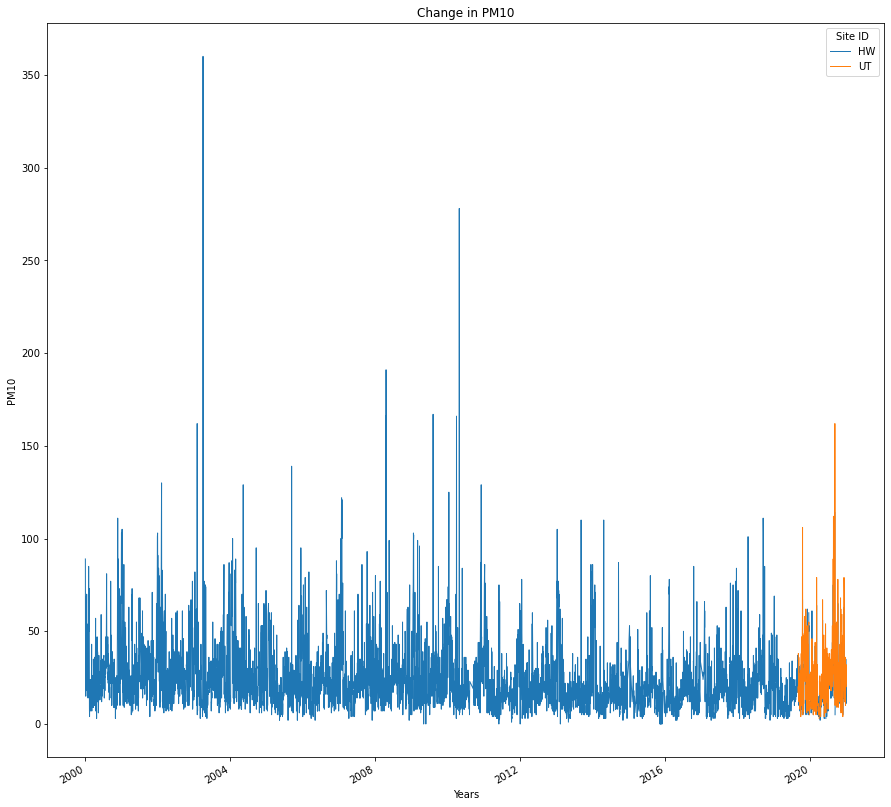

In [15]:
# PM10
ax = PM10_pivot.plot(figsize=(15,15), linewidth=1)
ax.set_xlabel("Years")
ax.set_ylabel("PM10")
ax.set_title("Change in PM10");

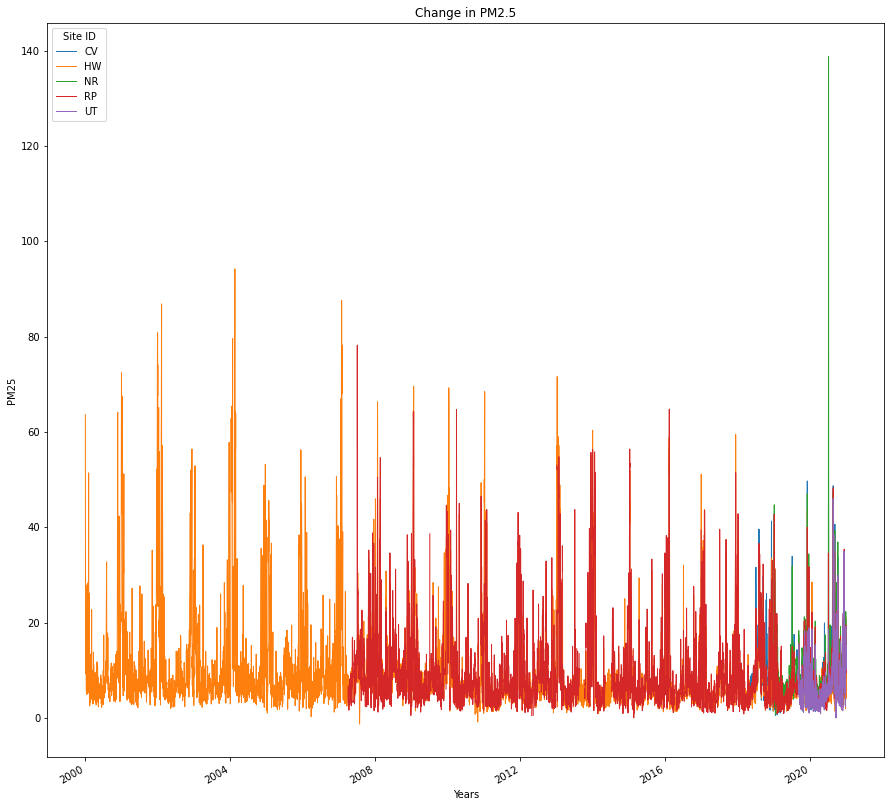

In [16]:
# PM25
ax1 = PM25_pivot.plot(figsize=(15,15),linewidth=1)
ax1.set_xlabel("Years")
ax1.set_ylabel("PM25")
ax1.set_title("Change in PM2.5");

**SECTION:** Descriptive Statistics

In [17]:
# Hourly PM2.5 data set
hourly_PM25.describe()

HW - Hawthorne  RP - Rose Park  LP - Lake View  UT - Utah Air  \
count   128334.000000    35518.000000     2135.000000    7188.000000   
mean         9.806311        8.363114       10.514286       4.053589   
std         11.638772        8.510794        7.557360       3.208126   
min       -100.000000      -10.000000        0.800000       0.000000   
25%          3.600000        3.300000        5.300000       1.900000   
50%          6.400000        6.000000        8.200000       3.300000   
75%         11.300000       10.500000       13.550000       5.100000   
max        655.600000      357.800000       47.100000      27.100000   

       NP - Near Road Murry  CV - Copper View  Average PM2.5  
count           8595.000000      22785.000000  129355.000000  
mean              10.395753          9.034093       9.891020  
std               10.302563          9.089246      11.625548  
min                0.400000         -1.200000    -100.000000  
25%                4.700000          3.900000       3.700000  
50%                8.000000          6.700000       6.500000  
75%               13.200000         11.000000      11.500000  
max              325.300000        289.200000     655.600000

In [18]:
# Daily EPA PM2.5 data set
PM10_pivot.describe()

Site ID           HW          UT
count    7067.000000  469.000000
mean       23.878591   26.829424
std        17.731007   17.112396
min         0.000000    3.000000
25%        13.000000   15.000000
50%        20.000000   23.000000
75%        29.000000   35.000000
max       360.000000  162.000000

In [19]:
# Daily EPA PM2.5 data set
PM25_pivot.describe()

Site ID          CV           HW          NR           RP          UT
count    947.000000  7564.000000  721.000000  4662.000000  482.000000
mean       8.964414     9.775285    9.771845     9.428893    7.436826
std        6.818031     9.973231    8.241767     8.578909    5.873091
min        0.500000    -1.300000    0.700000     0.000000    0.000000
25%        4.950000     4.566667    5.200000     4.400000    3.954167
50%        7.100000     6.600000    8.100000     6.700000    5.900000
75%       10.700000    10.300000   12.100000    10.787500    8.800000
max       49.700000    94.200000  138.800000    78.200000   46.000000

In [20]:
# Met data set
data_met.describe()

Wind Speed (m/s)  Wind Gust (m/s)  Wind Direction (deg)  \
count      1.447248e+07     9.253826e+06          1.348557e+07   
mean       2.906182e+00     4.582437e+00          1.712762e+02   
std        2.587971e+00     3.750413e+00          1.115643e+02   
min        0.000000e+00     0.000000e+00          0.000000e+00   
25%        9.000000e-01     1.790000e+00          7.900000e+01   
50%        2.500000e+00     3.580000e+00          1.700000e+02   
75%        4.120000e+00     6.400000e+00          2.700000e+02   
max        7.717000e+01     9.426000e+01          3.600000e+02   

       Barometric Pressure (Pascals)  
count                   9.222621e+06  
mean                    8.050704e+04  
std                     1.761693e+04  
min                     8.710000e+00  
25%                     7.360463e+04  
50%                     8.317307e+04  
75%                     8.666802e+04  
max                     1.896121e+06

## Seasonal Wind and Pollution Analysis

This section is where we investigate the relationships between wind and particulate matter. When defining seasonal trends, the standard in dividing seasons in atmospheric research is the following classification:

**Winter:** December, January, February

**Spring:** March, April, May

**Summer:** June, July, August

**Fall:** September, November, December

**SECTION:** Define functions and season dictionary

In [21]:
# Create a dictionary of the names of the seasons based on the month number
seasons = {3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
           9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter', 1: 'Winter', 2: 'Winter'}

# Function that extracts months and assigns month names
# Select the season of data desired
def seasonal_grouping(data, seasons, selection):
    data['Month'] = data['Datetime'].dt.month
    data['Season Name'] = data['Datetime'].dt.month.map(seasons)
    data = data[data['Season Name'] == selection].drop(columns = ['Month', 'Season Name'])
    return data

def wind_grouping(data, variable, degree_H, degree_L):
    
    # Create a pivot table for unfiltered data
    tmp = data.pivot_table(index = 'Datetime', columns = 'Station ID', values = variable)
    
    # Reset the index and create a column for dates
    tmp = tmp.reset_index()
    tmp['Date'] = tmp['Datetime'].dt.date

    # Counts
    counts = tmp.groupby('Date').count()
    counts['Observations'] = counts.iloc[:,1:len(counts.columns)].sum(axis = 1)
    counts['Salt Lake Observations'] = counts.loc[:,['KSLC', 'KU42', 'D6558', 'C8880', 'D6120']].sum(axis = 1)
    
    # Averages for full dataset
    averages = tmp.groupby('Date').mean()
    averages['All Salt Lake Average Wind Speed (m/s)'] = averages.loc[:,['KSLC', 'KU42', 'D6558', 'C8880', 'D6120']].mean(axis = 1)
    averages['All Great Salt Lake Average Wind Speed (m/s)'] = averages.loc[:,['GNI', 'HATUT', 'LMR', 'LMS']].mean(axis = 1)
    
    # Apply filter for specified wind directions
    tmp = data[(data['Wind Direction (deg)'] >= degree_L) & (data['Wind Direction (deg)'] <= degree_H)]
    tmp = tmp.pivot_table(index = 'Datetime', columns = 'Station ID', values = variable)

    # Reset the index and create a column for dates
    tmp = tmp.reset_index()
    tmp['Date'] = tmp['Datetime'].dt.date
    
    # Counts for filtered
    filtered = tmp.groupby('Date').count()
    filtered['Filtered Observations'] = filtered.iloc[:,1:len(filtered.columns)].sum(axis = 1)
    filtered['Salt Lake Filtered'] = filtered.loc[:,['KSLC', 'KU42', 'D6558', 'C8880', 'D6120']].sum(axis = 1)
    
    # Averages for dataset
    result = tmp.groupby('Date').mean()
    result['Filtered Salt Lake Average Wind Speed (m/s)'] = result.loc[:,['KSLC', 'KU42', 'D6558', 'C8880', 'D6120']].mean(axis = 1)
    result['Filtered Great Salt Lake Average Wind Speed (m/s)'] = result.loc[:,['GNI', 'HATUT', 'LMR', 'LMS']].mean(axis = 1)
    result = result.reset_index()
    result = result.sort_values('Date')
    result['All Salt Lake Average Wind Speed (m/s)'] = averages['All Salt Lake Average Wind Speed (m/s)'].values
    result['All Great Salt Lake Average Wind Speed (m/s)'] = averages['All Great Salt Lake Average Wind Speed (m/s)'].values
    result['Observations'] = counts['Observations'].values
    result['Filtered Observations'] = filtered['Filtered Observations'].values
    result['Salt Lake Observations'] = counts['Salt Lake Observations'].values
    result['Salt Lake Filtered'] = filtered['Salt Lake Filtered'].values
    result['Salt Lake Percentage Filtered'] = (result['Salt Lake Filtered'].values/result['Salt Lake Observations'])*100    
    
    return result


**SECTION:** Average pollution values across all sites to represent the Salt Lake Valley as a whole

In [22]:
# Reset the index to extract datetime column and use for grouping
# Additionally copy the dataframes from above to prevent replacement
# All datetime object variables are named Datetime
PM25_Hourly = hourly_PM25.reset_index().copy(deep = True)
PM25_Daily = PM25_pivot.reset_index().copy(deep = True)
PM10_Daily = PM10_pivot.reset_index().copy(deep = True)

# Extract the date
PM25_Daily['Date'] = PM25_Daily['Datetime'].dt.date
PM10_Daily['Date'] = PM10_Daily['Datetime'].dt.date

# Drop the Datetime column
PM25_Daily = PM25_Daily.drop(columns = 'Datetime')
PM10_Daily = PM10_Daily.drop(columns = 'Datetime')

# Average concentrations
PM25_Daily['Salt Lake Average PM 2.5 (ug/m^3)'] = PM25_Daily.iloc[:,0:5].mean(axis = 1)
PM10_Daily['Salt Lake Average PM 10 (ug/m^3)'] = PM10_Daily.iloc[:,0:1].mean(axis = 1)

# Drop extra columns
PM25_Daily = PM25_Daily.drop(columns = ["CV", "HW", "NR", "RP", "UT"])
PM10_Daily = PM10_Daily.drop(columns = ["HW", "UT"])


### Filtering Based on Wind Direction

One aspect of our research question was to test if wind speeds across the Great Salt Lake region had a statistically significant relationship between particulate matter concentrations in the Salt Lake Valley. To test this, we need to filter our data to only include wind speeds from the north west, which is where we would expect higher winds to pick up dust.

To accomplish this we can subset our data to only include rows that have wind direction from between 270 degrees (West) and 360/0 degrees (North). We also computed the same values but for all available data for comparison. Additionally, to show how much data was removed we included the number of observations per site per day before and after the wind direction filter was applied. The percentage shown in the *grouped* dataframe is how many observations were in the specified wind direction for that day out of the total.

**SECTION:** Apply function above which calculates the means and counts for wind data. Additionally merge the pollution datasets

In [23]:
# Extracting the month from Datetime column for grouping
MET_Hourly = data_met.reset_index().copy(deep = True)

# Apply function above
grouped = wind_grouping(MET_Hourly,'Wind Speed (m/s)', 360, 270)

# Add daily EPA pollution data
grouped = pd.merge(grouped, PM25_Daily, how = 'outer', on = 'Date')
grouped = pd.merge(grouped, PM10_Daily, how = 'outer', on = 'Date')
grouped

Date     ARAU1     AS768     C8845     C8846     C8880     D6120  \
0     2000-01-01  0.767500       NaN       NaN       NaN       NaN       NaN   
1     2000-01-02  3.488000       NaN       NaN       NaN       NaN       NaN   
2     2000-01-03  2.828333       NaN       NaN       NaN       NaN       NaN   
3     2000-01-04  1.353333       NaN       NaN       NaN       NaN       NaN   
4     2000-01-05  4.812667       NaN       NaN       NaN       NaN       NaN   
...          ...       ...       ...       ...       ...       ...       ...   
7766  2021-04-07  2.233333  2.204667       NaN  1.676250  1.479231  1.300476   
7767  2021-04-08  5.980000  3.334167  4.109367  6.938542  1.628058  2.058485   
7768  2021-04-09  2.592000  1.900000  1.825000  1.622500  1.053510  1.571818   
7769  2021-04-10       NaN  0.900000       NaN  1.565000  0.900000       NaN   
7770  2000-02-28       NaN       NaN       NaN       NaN       NaN       NaN   

         D6558       GNI     HATUT  ...  \
0          NaN  3.692500  5.350000  ...   
1          NaN  5.465122  5.301905  ...   
2          NaN  8.616000  9.146410  ...   
3          NaN  2.982000  4.098333  ...   
4          NaN  7.257556  8.015283  ...   
...        ...       ...       ...  ...   
7766  0.730000  2.505000  1.856364  ...   
7767  2.088316  8.441653  7.935417  ...   
7768  1.035410  5.149242  2.701000  ...   
7769       NaN  3.390455       NaN  ...   
7770       NaN       NaN       NaN  ...   

      Filtered Great Salt Lake Average Wind Speed (m/s)  \
0                                              3.631333   
1                                              5.192043   
2                                              6.825498   
3                                              2.879105   
4                                              6.590983   
...                                                 ...   
7766                                           2.062863   
7767                                           7.867911   
7768                                           3.598636   
7769                                           2.471477   
7770                                                NaN   

      All Salt Lake Average Wind Speed (m/s)  \
0                                   0.724074   
1                                   2.725405   
2                                   3.515556   
3                                   3.756061   
4                                   2.294615   
...                                      ...   
7766                                2.103107   
7767                                2.704524   
7768                                1.912474   
7769                                1.531761   
7770                                     NaN   

      All Great Salt Lake Average Wind Speed (m/s)  Observations  \
0                                         3.355697         326.0   
1                                         5.016667         535.0   
2                                         5.108073         537.0   
3                                         3.424635         525.0   
4                                         5.627630         460.0   
...                                            ...           ...   
7766                                      4.192457        3517.0   
7767                                      6.635052        3568.0   
7768                                      4.407005        3551.0   
7769                                      3.679713         748.0   
7770                                           NaN           NaN   

      Filtered Observations  Salt Lake Observations  Salt Lake Filtered  \
0                      51.0                    27.0                 4.0   
1                     293.0                    37.0                17.0   
2                     186.0                    36.0                10.0   
3                     115.0                    33.0                 7.0   
4                     268.0                    13.0     

In [24]:
# To note which columns we have in the grouped dataframe
grouped.columns

Index(['Date', 'ARAU1', 'AS768', 'C8845', 'C8846', 'C8880', 'D6120', 'D6558',
       'GNI', 'HATUT', 'KBMC', 'KENV', 'KOGD', 'KSLC', 'KTVY', 'KU42', 'LMR',
       'LMS', 'RSBU1', 'UCC01', 'UT9',
       'Filtered Salt Lake Average Wind Speed (m/s)',
       'Filtered Great Salt Lake Average Wind Speed (m/s)',
       'All Salt Lake Average Wind Speed (m/s)',
       'All Great Salt Lake Average Wind Speed (m/s)', 'Observations',
       'Filtered Observations', 'Salt Lake Observations', 'Salt Lake Filtered',
       'Salt Lake Percentage Filtered', 'Salt Lake Average PM 2.5 (ug/m^3)',
       'Salt Lake Average PM 10 (ug/m^3)'],
      dtype='object')

**SECTION:** Subset the data and add seasonal identifiers

In [25]:
# Subset
paired_data = grouped.iloc[:,[0, 21, 22, 23, 24, 30, 31]].copy(deep = True)

# Add seasons column
paired_data['Month'] = pd.to_datetime(paired_data['Date']).dt.month
paired_data['Season'] = pd.to_datetime(paired_data['Date']).dt.month.map(seasons)
paired_data = paired_data.sort_values('Date').drop(columns = ['Month'])
paired_data

Date  Filtered Salt Lake Average Wind Speed (m/s)  \
0     2000-01-01                                     1.800000   
1     2000-01-02                                     3.178235   
2     2000-01-03                                     5.195000   
3     2000-01-04                                     2.938571   
4     2000-01-05                                     3.014286   
...          ...                                          ...   
7765  2021-04-06                                     2.977942   
7766  2021-04-07                                     1.681608   
7767  2021-04-08                                     3.598160   
7768  2021-04-09                                     2.136356   
7769  2021-04-10                                     0.900000   

      Filtered Great Salt Lake Average Wind Speed (m/s)  \
0                                              3.631333   
1                                              5.192043   
2                                              6.825498   
3                                              2.879105   
4                                              6.590983   
...                                                 ...   
7765                                           7.964607   
7766                                           2.062863   
7767                                           7.867911   
7768                                           3.598636   
7769                                           2.471477   

      All Salt Lake Average Wind Speed (m/s)  \
0                                   0.724074   
1                                   2.725405   
2                                   3.515556   
3                                   3.756061   
4                                   2.294615   
...                                      ...   
7765                                2.101556   
7766                                2.103107   
7767                                2.704524   
7768                                1.912474   
7769                                1.531761   

      All Great Salt Lake Average Wind Speed (m/s)  \
0                                         3.355697   
1                                         5.016667   
2                                         5.108073   
3                                         3.424635   
4                                         5.627630   
...                                            ...   
7765                                      6.442899   
7766                                      4.192457   
7767                                      6.635052   
7768                                      4.407005   
7769                                      3.679713   

      Salt Lake Average PM 2.5 (ug/m^3)  Salt Lake Average PM 10 (ug/m^3)  \
0                                  63.6                              89.0   
1                                  18.3                              26.0   
2                                  10.0                              19.0   
3                                  14.7                              32.0   
4                                   9.2                              15.0   
...                                 ...                               ...   
7765                                NaN                               NaN   
7766                                NaN                               NaN   
7767                                NaN                               NaN   
7768                                NaN                               NaN   
7769                                NaN                               NaN   

      Season  
0     Winter  
1     Winter  
2     Winter  
3     Winter  
4     Winter  
...      ...  
7765  Spring  
7766  Spring  
7767  Spring  
7768  Spring  
7769  Spring  

[7771 rows x 8 columns]

### Correlation Plots and Spearman Correlations

The following section analyzes how different bins of wind speed affect potential relationships between wind speed and pollution in Salt Lake. For each subset of wind speeds we have included a seaborn pairplot wiht histograms along the diagonal. The plots are ordered by "hue" which corresponds to different seasons. We are specifically looking at correlations between wind speeds and PM2.5 and PM10. Also included above each plot is a table of spearman correlation coefficients.

We chose the Spearman correlation method rather than Pearson because on the potential on non-linearity. Our relationship may be non-linear, so by using Spearman we avoid potential issues arising from applying a linear correlation model to a non-linear relationship.

#### All Wind Speeds

One interesting thing to note is the strong linear relationship between PM2.5 and PM10 for the winter. This is the wintertime inversion signal that we would expect to see.

Filtered Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                           1.000000   
Filtered Great Salt Lake Average Wind Speed (m/s)                                     0.309592   
All Salt Lake Average Wind Speed (m/s)                                                0.661370   
All Great Salt Lake Average Wind Speed (m/s)                                          0.212779   
Salt Lake Average PM 2.5 (ug/m^3)                                                    -0.119776   
Salt Lake Average PM 10 (ug/m^3)                                                      0.017388   

                                                   Filtered Great Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                                 0.309592   
Filtered Great Salt Lake Average Wind Speed (m/s)                                           1.000000   
All Salt Lake Average Wind Speed (m/s)                                                      0.209556   
All Great Salt Lake Average Wind Speed (m/s)                                                0.792700   
Salt Lake Average PM 2.5 (ug/m^3)                                                          -0.384791   
Salt Lake Average PM 10 (ug/m^3)                                                           -0.300191   

                                                   All Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                      0.661370   
Filtered Great Salt Lake Average Wind Speed (m/s)                                0.209556   
All Salt Lake Average Wind Speed (m/s)                                           1.000000   
All Great Salt Lake Average Wind Speed (m/s)                                     0.305866   
Salt Lake Average PM 2.5 (ug/m^3)                                               -0.255570   
Salt Lake Average PM 10 (ug/m^3)                                                -0.031669   

                                                   All Great Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                            0.212779   
Filtered Great Salt Lake Average Wind Speed (m/s)                                      0.792700   
All Salt Lake Average Wind Speed (m/s)                                                 0.305866   
All Great Salt Lake Average Wind Speed (m/s)                                           1.000000   
Salt Lake Average PM 2.5 (ug/m^3)                                                     -0.476927   
Salt Lake Average PM 10 (ug/m^3)                                                      -0.373772   

                                                   Salt Lake Average PM 2.5 (ug/m^3)  \
Filtered Salt Lake Average Wind Speed (m/s)                                -0.119776   
Filtered Great Salt Lake Average Wind Speed (m/s)                          -0.384791   
All Salt Lake Average Wind Speed (m/s)                                     -0.255570   
All Great Salt Lake Average Wind Speed (m/s)                               -0.476927   
Salt Lake Average PM 2.5 (ug/m^3)                                           1.000000   
Salt Lake Average PM 10 (ug/m^3)                                            0.805856   

                                                   Salt Lake Average PM 10 (ug/m^3)  
Filtered Salt Lake Average Wind Speed (m/s)                                0.017388  
Filtered Great Salt Lake Average Wind Speed (m/s)                         -0.300191  
All Salt Lake Average Wind Speed (m/s)                                    -0.031669  
All Great Salt Lake Average Wind Speed (m/s)                              -0.373772  
Salt Lake Average PM 2.5 (ug/m^3)                                          0.805856  
Salt Lake Average PM 10 (ug/m^3)                                           1.000000

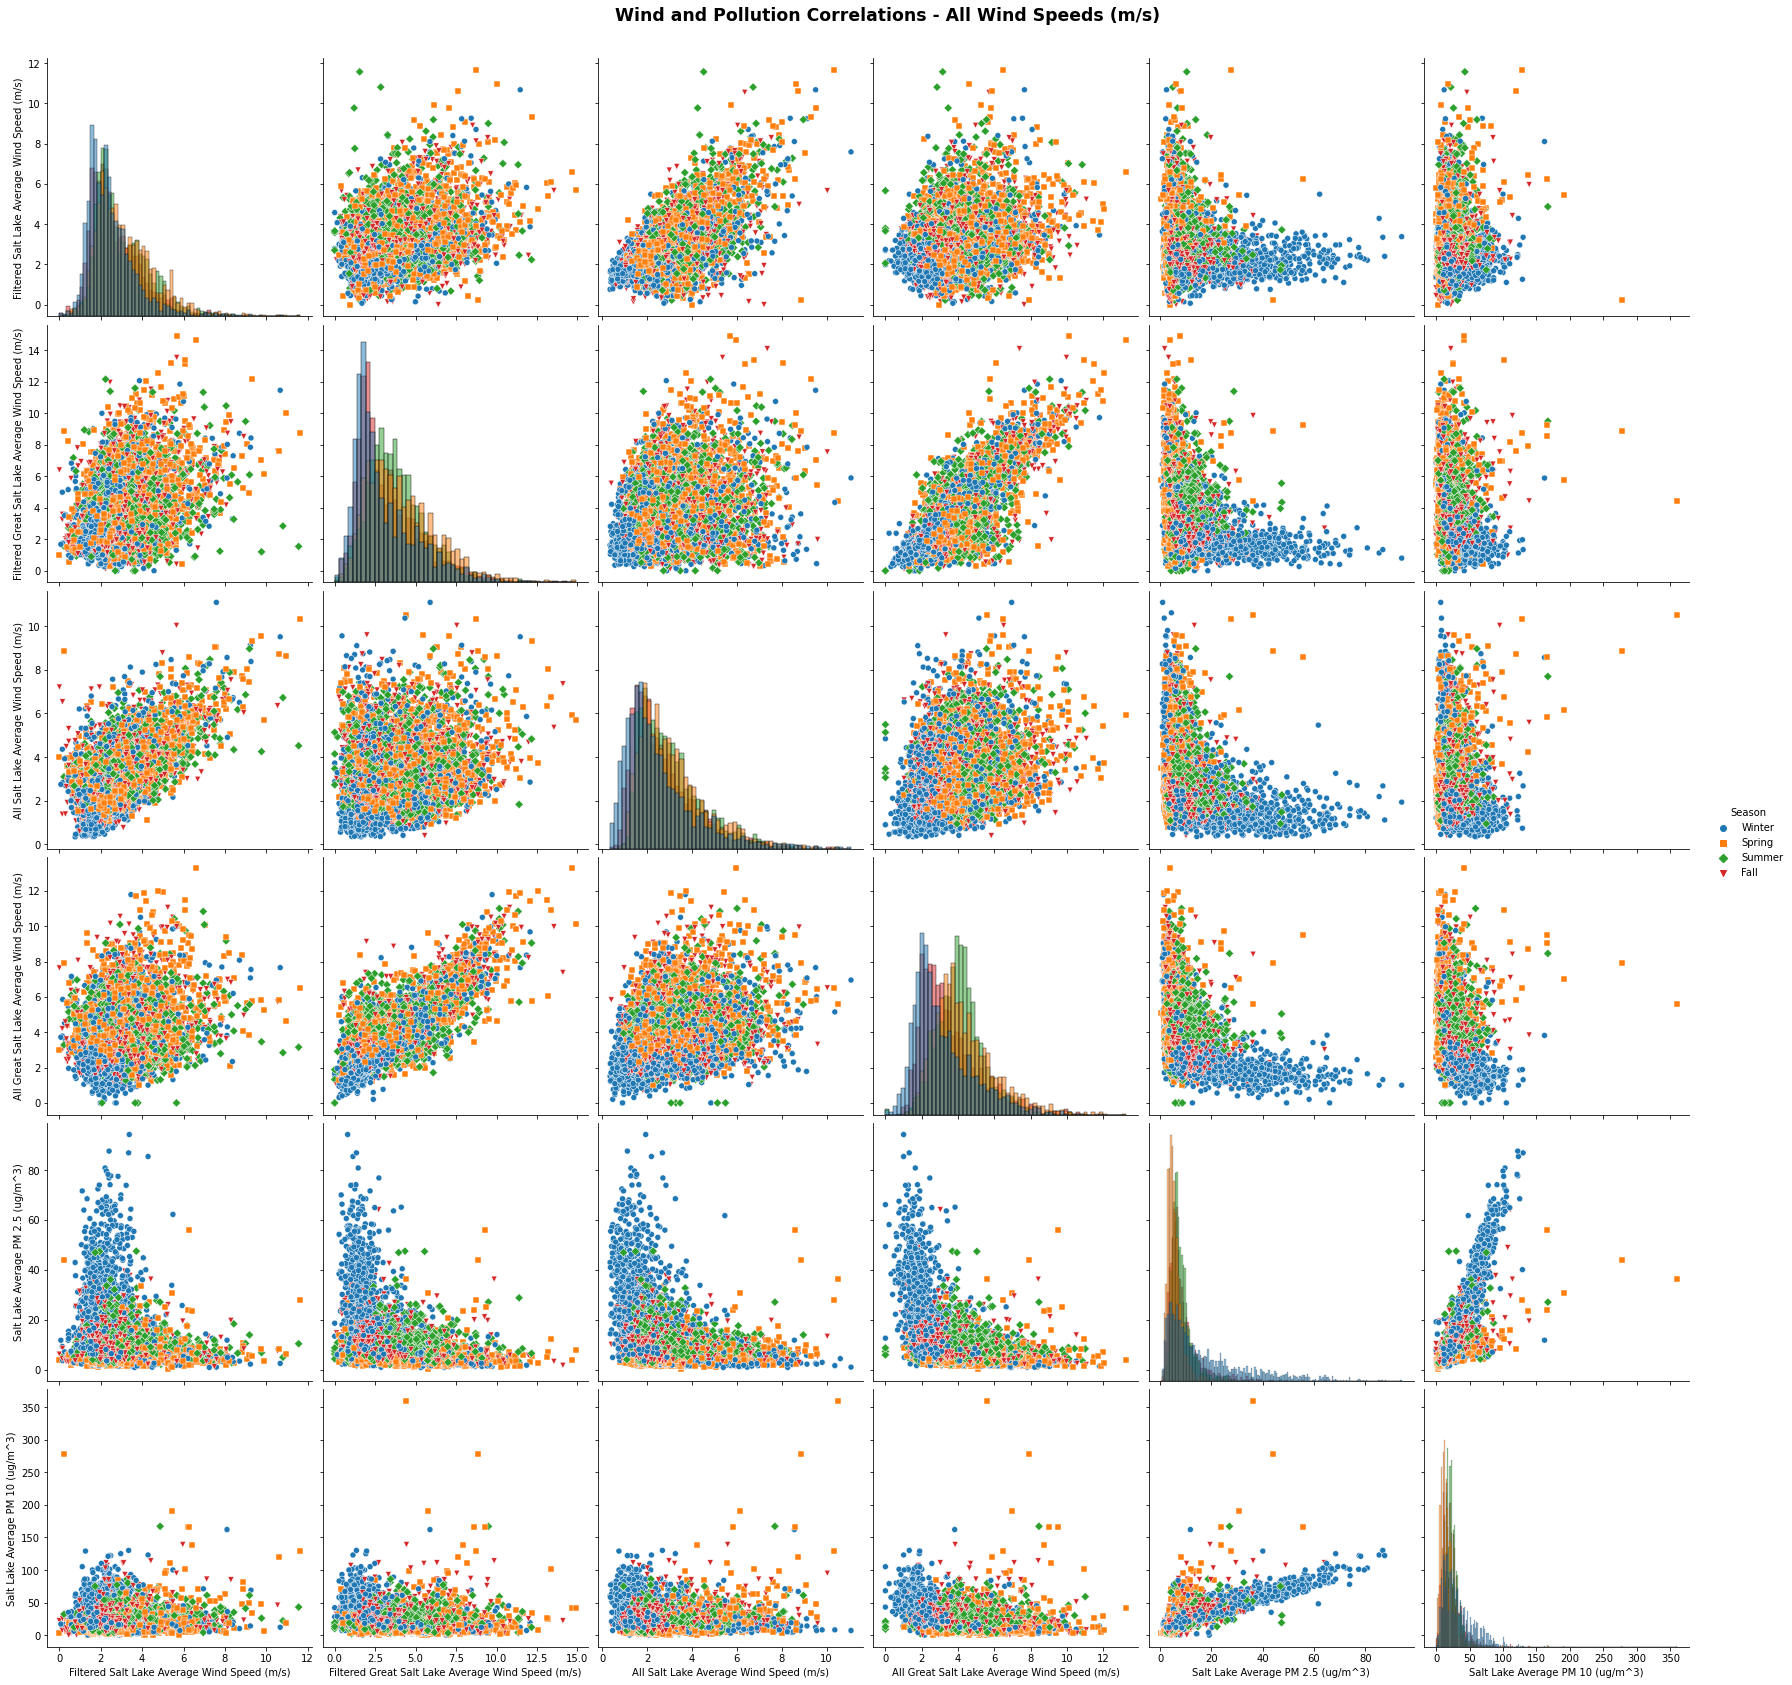

In [26]:
# Pairplots
overall_plot = sns.pairplot(paired_data,
                            hue = "Season",
                            markers=["o", "s", "D", "v"],
                            diag_kind = "hist",
                            hue_order = ["Winter", "Spring", "Summer", "Fall"],
                            height = 4)

# move overall title up
overall_plot.fig.subplots_adjust(top = 0.95)

# add overall title
overall_plot.fig.suptitle('Wind and Pollution Correlations - All Wind Speeds (m/s)', size = 'xx-large', weight = "bold");

# Find the correlations
correlations_all = paired_data.corr(method = "spearman")
correlations_all


#### Lower Wind Speeds (0-5 m/s)

Here we still see the strong wintertime inversion signal present. In order for Persistent Cold Air Pools to last during the winter, we need weak winds. Strong winds would remove the capping layer and allow the valley to "air out."

The correlation values are lower for filtered wind direction data than all data, similar to the dataset above.

Filtered Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                           1.000000   
Filtered Great Salt Lake Average Wind Speed (m/s)                                     0.167237   
All Salt Lake Average Wind Speed (m/s)                                                0.604835   
All Great Salt Lake Average Wind Speed (m/s)                                          0.052311   
Salt Lake Average PM 2.5 (ug/m^3)                                                    -0.069755   
Salt Lake Average PM 10 (ug/m^3)                                                      0.042517   

                                                   Filtered Great Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                                 0.167237   
Filtered Great Salt Lake Average Wind Speed (m/s)                                           1.000000   
All Salt Lake Average Wind Speed (m/s)                                                      0.056269   
All Great Salt Lake Average Wind Speed (m/s)                                                0.657446   
Salt Lake Average PM 2.5 (ug/m^3)                                                          -0.312642   
Salt Lake Average PM 10 (ug/m^3)                                                           -0.299844   

                                                   All Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                      0.604835   
Filtered Great Salt Lake Average Wind Speed (m/s)                                0.056269   
All Salt Lake Average Wind Speed (m/s)                                           1.000000   
All Great Salt Lake Average Wind Speed (m/s)                                     0.227628   
Salt Lake Average PM 2.5 (ug/m^3)                                               -0.268190   
Salt Lake Average PM 10 (ug/m^3)                                                -0.062205   

                                                   All Great Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                            0.052311   
Filtered Great Salt Lake Average Wind Speed (m/s)                                      0.657446   
All Salt Lake Average Wind Speed (m/s)                                                 0.227628   
All Great Salt Lake Average Wind Speed (m/s)                                           1.000000   
Salt Lake Average PM 2.5 (ug/m^3)                                                     -0.457784   
Salt Lake Average PM 10 (ug/m^3)                                                      -0.405713   

                                                   Salt Lake Average PM 2.5 (ug/m^3)  \
Filtered Salt Lake Average Wind Speed (m/s)                                -0.069755   
Filtered Great Salt Lake Average Wind Speed (m/s)                          -0.312642   
All Salt Lake Average Wind Speed (m/s)                                     -0.268190   
All Great Salt Lake Average Wind Speed (m/s)                               -0.457784   
Salt Lake Average PM 2.5 (ug/m^3)                                           1.000000   
Salt Lake Average PM 10 (ug/m^3)                                            0.818252   

                                                   Salt Lake Average PM 10 (ug/m^3)  
Filtered Salt Lake Average Wind Speed (m/s)                                0.042517  
Filtered Great Salt Lake Average Wind Speed (m/s)                         -0.299844  
All Salt Lake Average Wind Speed (m/s)                                    -0.062205  
All Great Salt Lake Average Wind Speed (m/s)                              -0.405713  
Salt Lake Average PM 2.5 (ug/m^3)                                          0.818252  
Salt Lake Average PM 10 (ug/m^3)                                           1.000000

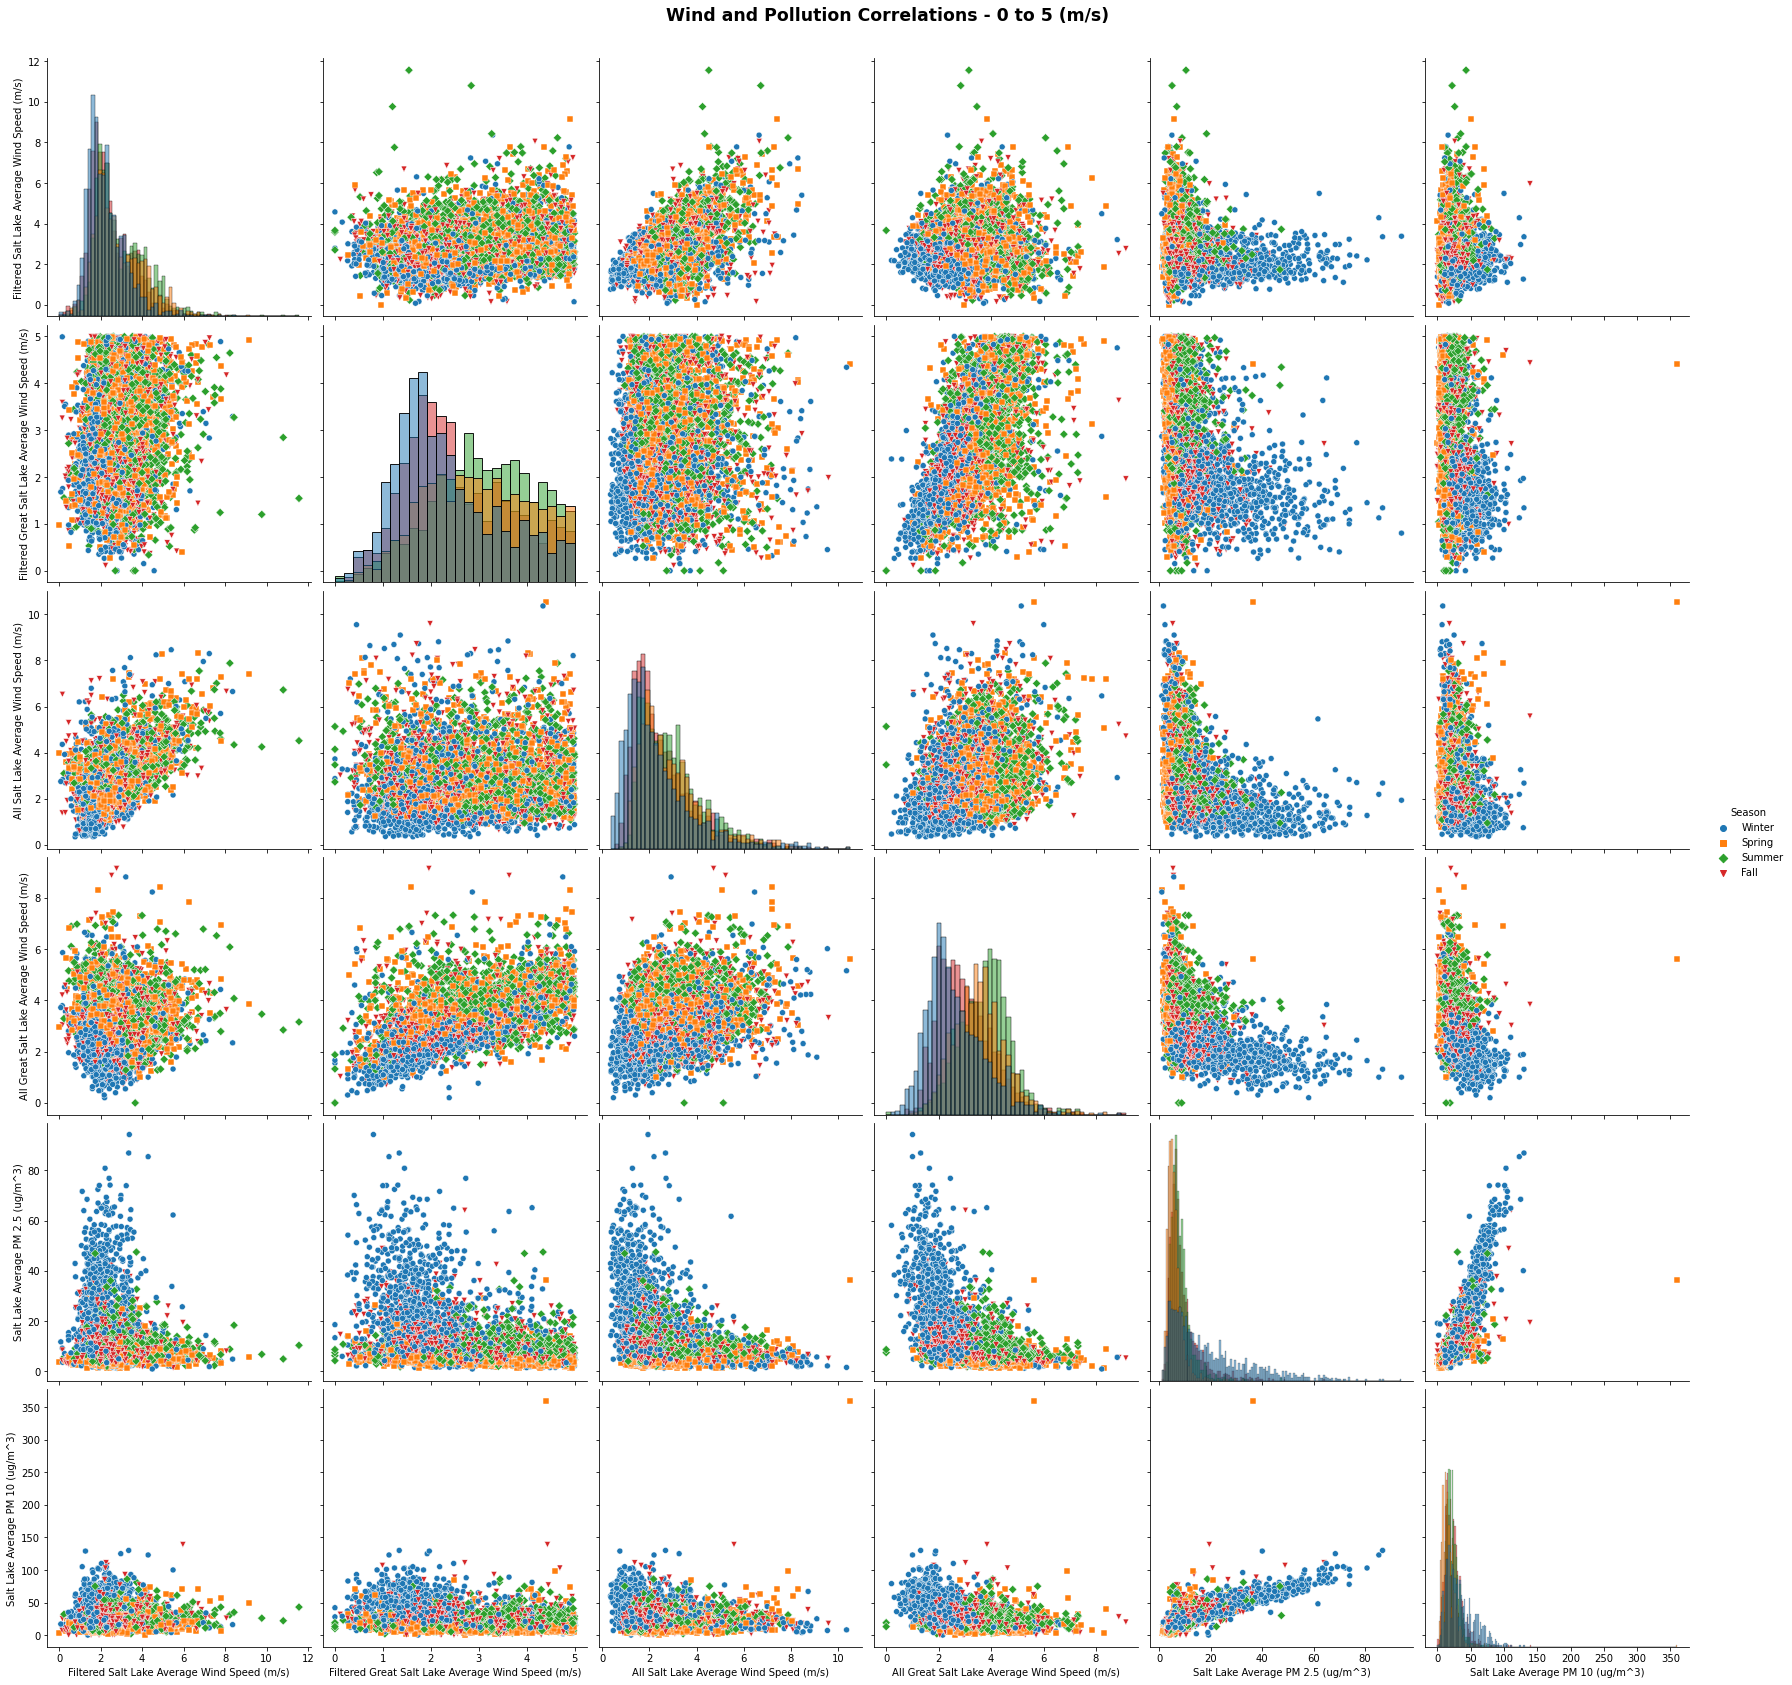

In [27]:
# Filter Great Salt Lake Wind Speeds
tmp = paired_data[(paired_data['Filtered Great Salt Lake Average Wind Speed (m/s)'] >= 0) &
                  (paired_data['Filtered Great Salt Lake Average Wind Speed (m/s)'] <= 5)].copy(deep = True)

lowerspeeds_plot = sns.pairplot(tmp,
                                hue = "Season",
                                markers=["o", "s", "D", "v"],
                                diag_kind = "hist",
                                hue_order = ["Winter", "Spring", "Summer", "Fall"],
                                height = 4)

#move overall title up
lowerspeeds_plot.fig.subplots_adjust(top = 0.95)

#add overall title
lowerspeeds_plot.fig.suptitle('Wind and Pollution Correlations - 0 to 5 (m/s)', size = 'xx-large', weight = "bold");

# Find the correlations
correlations_lowspeeds = tmp.corr(method = "spearman")
correlations_lowspeeds


#### Mid-range Wind Speeds (5-10 m/s)

With these higher winds, the winter inversion trend disappears entirely. Additionally the correlations drop dramatically as well. The predominant values of wind remaining are either in the spring or summer months.

Filtered Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                           1.000000   
Filtered Great Salt Lake Average Wind Speed (m/s)                                     0.294483   
All Salt Lake Average Wind Speed (m/s)                                                0.763817   
All Great Salt Lake Average Wind Speed (m/s)                                          0.164076   
Salt Lake Average PM 2.5 (ug/m^3)                                                     0.004654   
Salt Lake Average PM 10 (ug/m^3)                                                      0.137682   

                                                   Filtered Great Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                                 0.294483   
Filtered Great Salt Lake Average Wind Speed (m/s)                                           1.000000   
All Salt Lake Average Wind Speed (m/s)                                                      0.279033   
All Great Salt Lake Average Wind Speed (m/s)                                                0.635166   
Salt Lake Average PM 2.5 (ug/m^3)                                                          -0.111896   
Salt Lake Average PM 10 (ug/m^3)                                                            0.020167   

                                                   All Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                      0.763817   
Filtered Great Salt Lake Average Wind Speed (m/s)                                0.279033   
All Salt Lake Average Wind Speed (m/s)                                           1.000000   
All Great Salt Lake Average Wind Speed (m/s)                                     0.185899   
Salt Lake Average PM 2.5 (ug/m^3)                                                0.014840   
Salt Lake Average PM 10 (ug/m^3)                                                 0.250686   

                                                   All Great Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                            0.164076   
Filtered Great Salt Lake Average Wind Speed (m/s)                                      0.635166   
All Salt Lake Average Wind Speed (m/s)                                                 0.185899   
All Great Salt Lake Average Wind Speed (m/s)                                           1.000000   
Salt Lake Average PM 2.5 (ug/m^3)                                                     -0.197330   
Salt Lake Average PM 10 (ug/m^3)                                                      -0.091125   

                                                   Salt Lake Average PM 2.5 (ug/m^3)  \
Filtered Salt Lake Average Wind Speed (m/s)                                 0.004654   
Filtered Great Salt Lake Average Wind Speed (m/s)                          -0.111896   
All Salt Lake Average Wind Speed (m/s)                                      0.014840   
All Great Salt Lake Average Wind Speed (m/s)                               -0.197330   
Salt Lake Average PM 2.5 (ug/m^3)                                           1.000000   
Salt Lake Average PM 10 (ug/m^3)                                            0.755420   

                                                   Salt Lake Average PM 10 (ug/m^3)  
Filtered Salt Lake Average Wind Speed (m/s)                                0.137682  
Filtered Great Salt Lake Average Wind Speed (m/s)                          0.020167  
All Salt Lake Average Wind Speed (m/s)                                     0.250686  
All Great Salt Lake Average Wind Speed (m/s)                              -0.091125  
Salt Lake Average PM 2.5 (ug/m^3)                                          0.755420  
Salt Lake Average PM 10 (ug/m^3)                                           1.000000

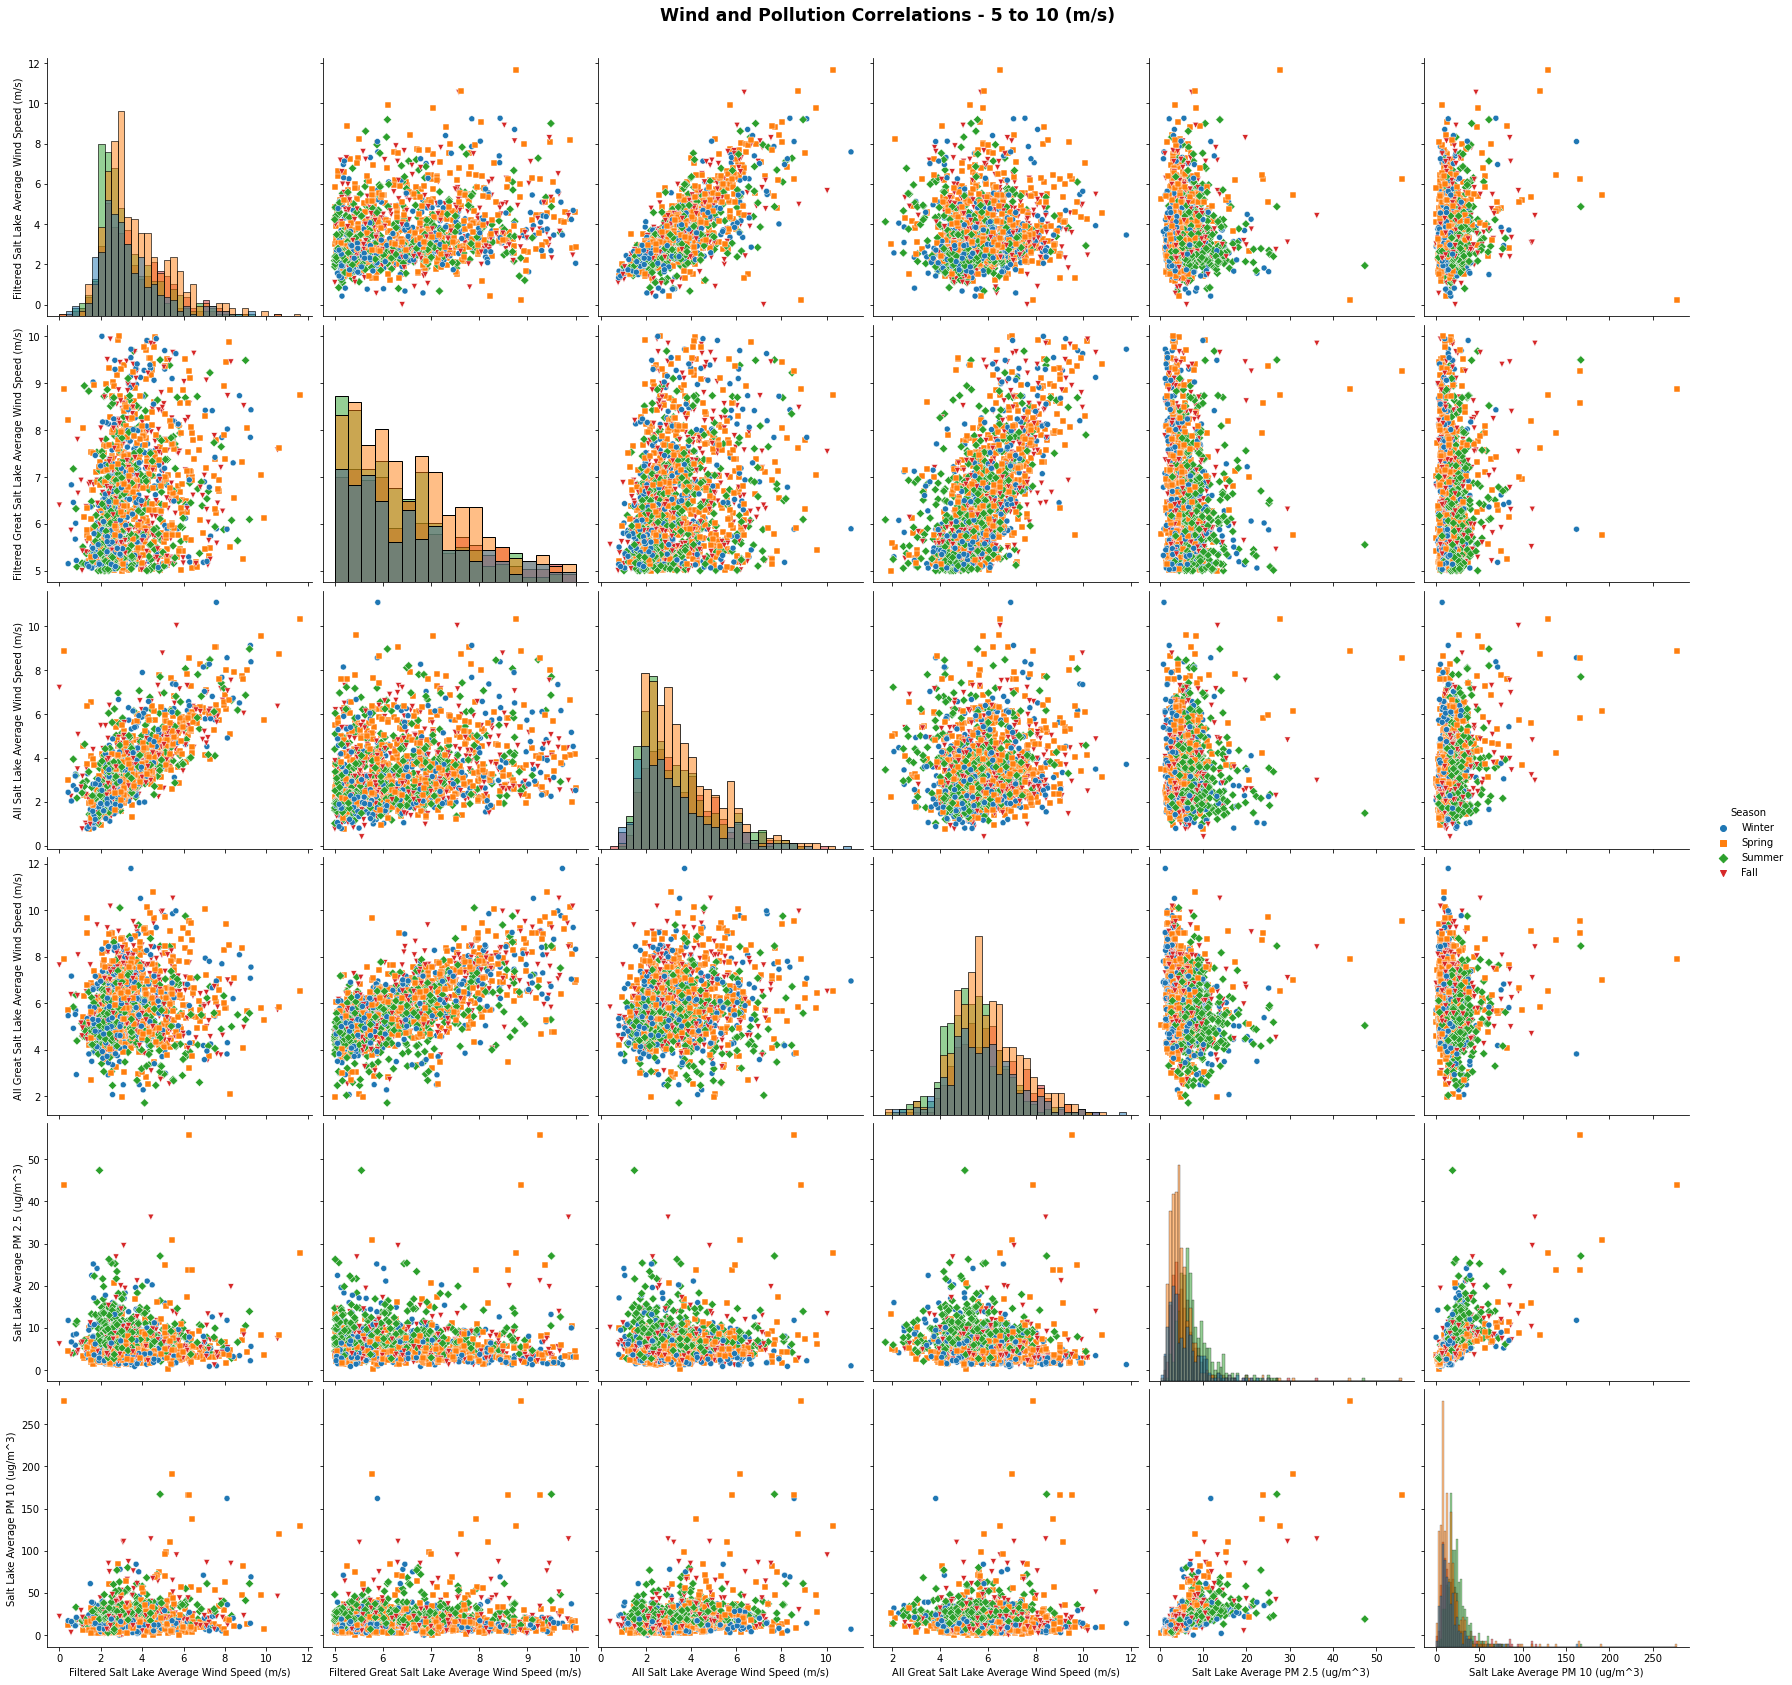

In [28]:
# Filter Great Salt Lake Wind Speeds
tmp = paired_data[(paired_data['Filtered Great Salt Lake Average Wind Speed (m/s)'] >= 5) &
                  (paired_data['Filtered Great Salt Lake Average Wind Speed (m/s)'] <= 10)]

medspeeds_plot = sns.pairplot(tmp,
                              hue = "Season",
                              markers=["o", "s", "D", "v"],
                              diag_kind = "hist",
                              hue_order = ["Winter", "Spring", "Summer", "Fall"],
                              height = 4)

#move overall title up
medspeeds_plot.fig.subplots_adjust(top = 0.95)

#add overall title
medspeeds_plot.fig.suptitle('Wind and Pollution Correlations - 5 to 10 (m/s)', size = 'xx-large', weight = "bold");

# Find the correlations
correlations_medspeeds = tmp.corr(method = "spearman")
correlations_medspeeds


#### High Wind Speeds (10+ m/s)

The most frequent higher wind speeds occur during the spring. Notice that there appears to be no significant linear correlations (according to the plots) between wind and particulate matter concentrations.

The Spearman correlation coefficients are very low for any correlation between wind and PM2.5, but are higher for relationships with PM10. Additionally, the coefficients for all other wind subsets are negative. Now for these higher wind speeds the correlations are positive. The largest non-PM correlation is between all Salt Lake daily average wind speeds and PM10 concentrations. The second highest is for filtered, which is expected as it is a subset of the data.

Filtered Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                           1.000000   
Filtered Great Salt Lake Average Wind Speed (m/s)                                     0.209834   
All Salt Lake Average Wind Speed (m/s)                                                0.764513   
All Great Salt Lake Average Wind Speed (m/s)                                          0.090223   
Salt Lake Average PM 2.5 (ug/m^3)                                                     0.017877   
Salt Lake Average PM 10 (ug/m^3)                                                      0.348106   

                                                   Filtered Great Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                                 0.209834   
Filtered Great Salt Lake Average Wind Speed (m/s)                                           1.000000   
All Salt Lake Average Wind Speed (m/s)                                                      0.247847   
All Great Salt Lake Average Wind Speed (m/s)                                                0.149077   
Salt Lake Average PM 2.5 (ug/m^3)                                                          -0.038483   
Salt Lake Average PM 10 (ug/m^3)                                                            0.133436   

                                                   All Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                      0.764513   
Filtered Great Salt Lake Average Wind Speed (m/s)                                0.247847   
All Salt Lake Average Wind Speed (m/s)                                           1.000000   
All Great Salt Lake Average Wind Speed (m/s)                                    -0.094532   
Salt Lake Average PM 2.5 (ug/m^3)                                                0.166849   
Salt Lake Average PM 10 (ug/m^3)                                                 0.469143   

                                                   All Great Salt Lake Average Wind Speed (m/s)  \
Filtered Salt Lake Average Wind Speed (m/s)                                            0.090223   
Filtered Great Salt Lake Average Wind Speed (m/s)                                      0.149077   
All Salt Lake Average Wind Speed (m/s)                                                -0.094532   
All Great Salt Lake Average Wind Speed (m/s)                                           1.000000   
Salt Lake Average PM 2.5 (ug/m^3)                                                     -0.129870   
Salt Lake Average PM 10 (ug/m^3)                                                      -0.072790   

                                                   Salt Lake Average PM 2.5 (ug/m^3)  \
Filtered Salt Lake Average Wind Speed (m/s)                                 0.017877   
Filtered Great Salt Lake Average Wind Speed (m/s)                          -0.038483   
All Salt Lake Average Wind Speed (m/s)                                      0.166849   
All Great Salt Lake Average Wind Speed (m/s)                               -0.129870   
Salt Lake Average PM 2.5 (ug/m^3)                                           1.000000   
Salt Lake Average PM 10 (ug/m^3)                                            0.712531   

                                                   Salt Lake Average PM 10 (ug/m^3)  
Filtered Salt Lake Average Wind Speed (m/s)                                0.348106  
Filtered Great Salt Lake Average Wind Speed (m/s)                          0.133436  
All Salt Lake Average Wind Speed (m/s)                                     0.469143  
All Great Salt Lake Average Wind Speed (m/s)                              -0.072790  
Salt Lake Average PM 2.5 (ug/m^3)                                          0.712531  
Salt Lake Average PM 10 (ug/m^3)                                           1.000000

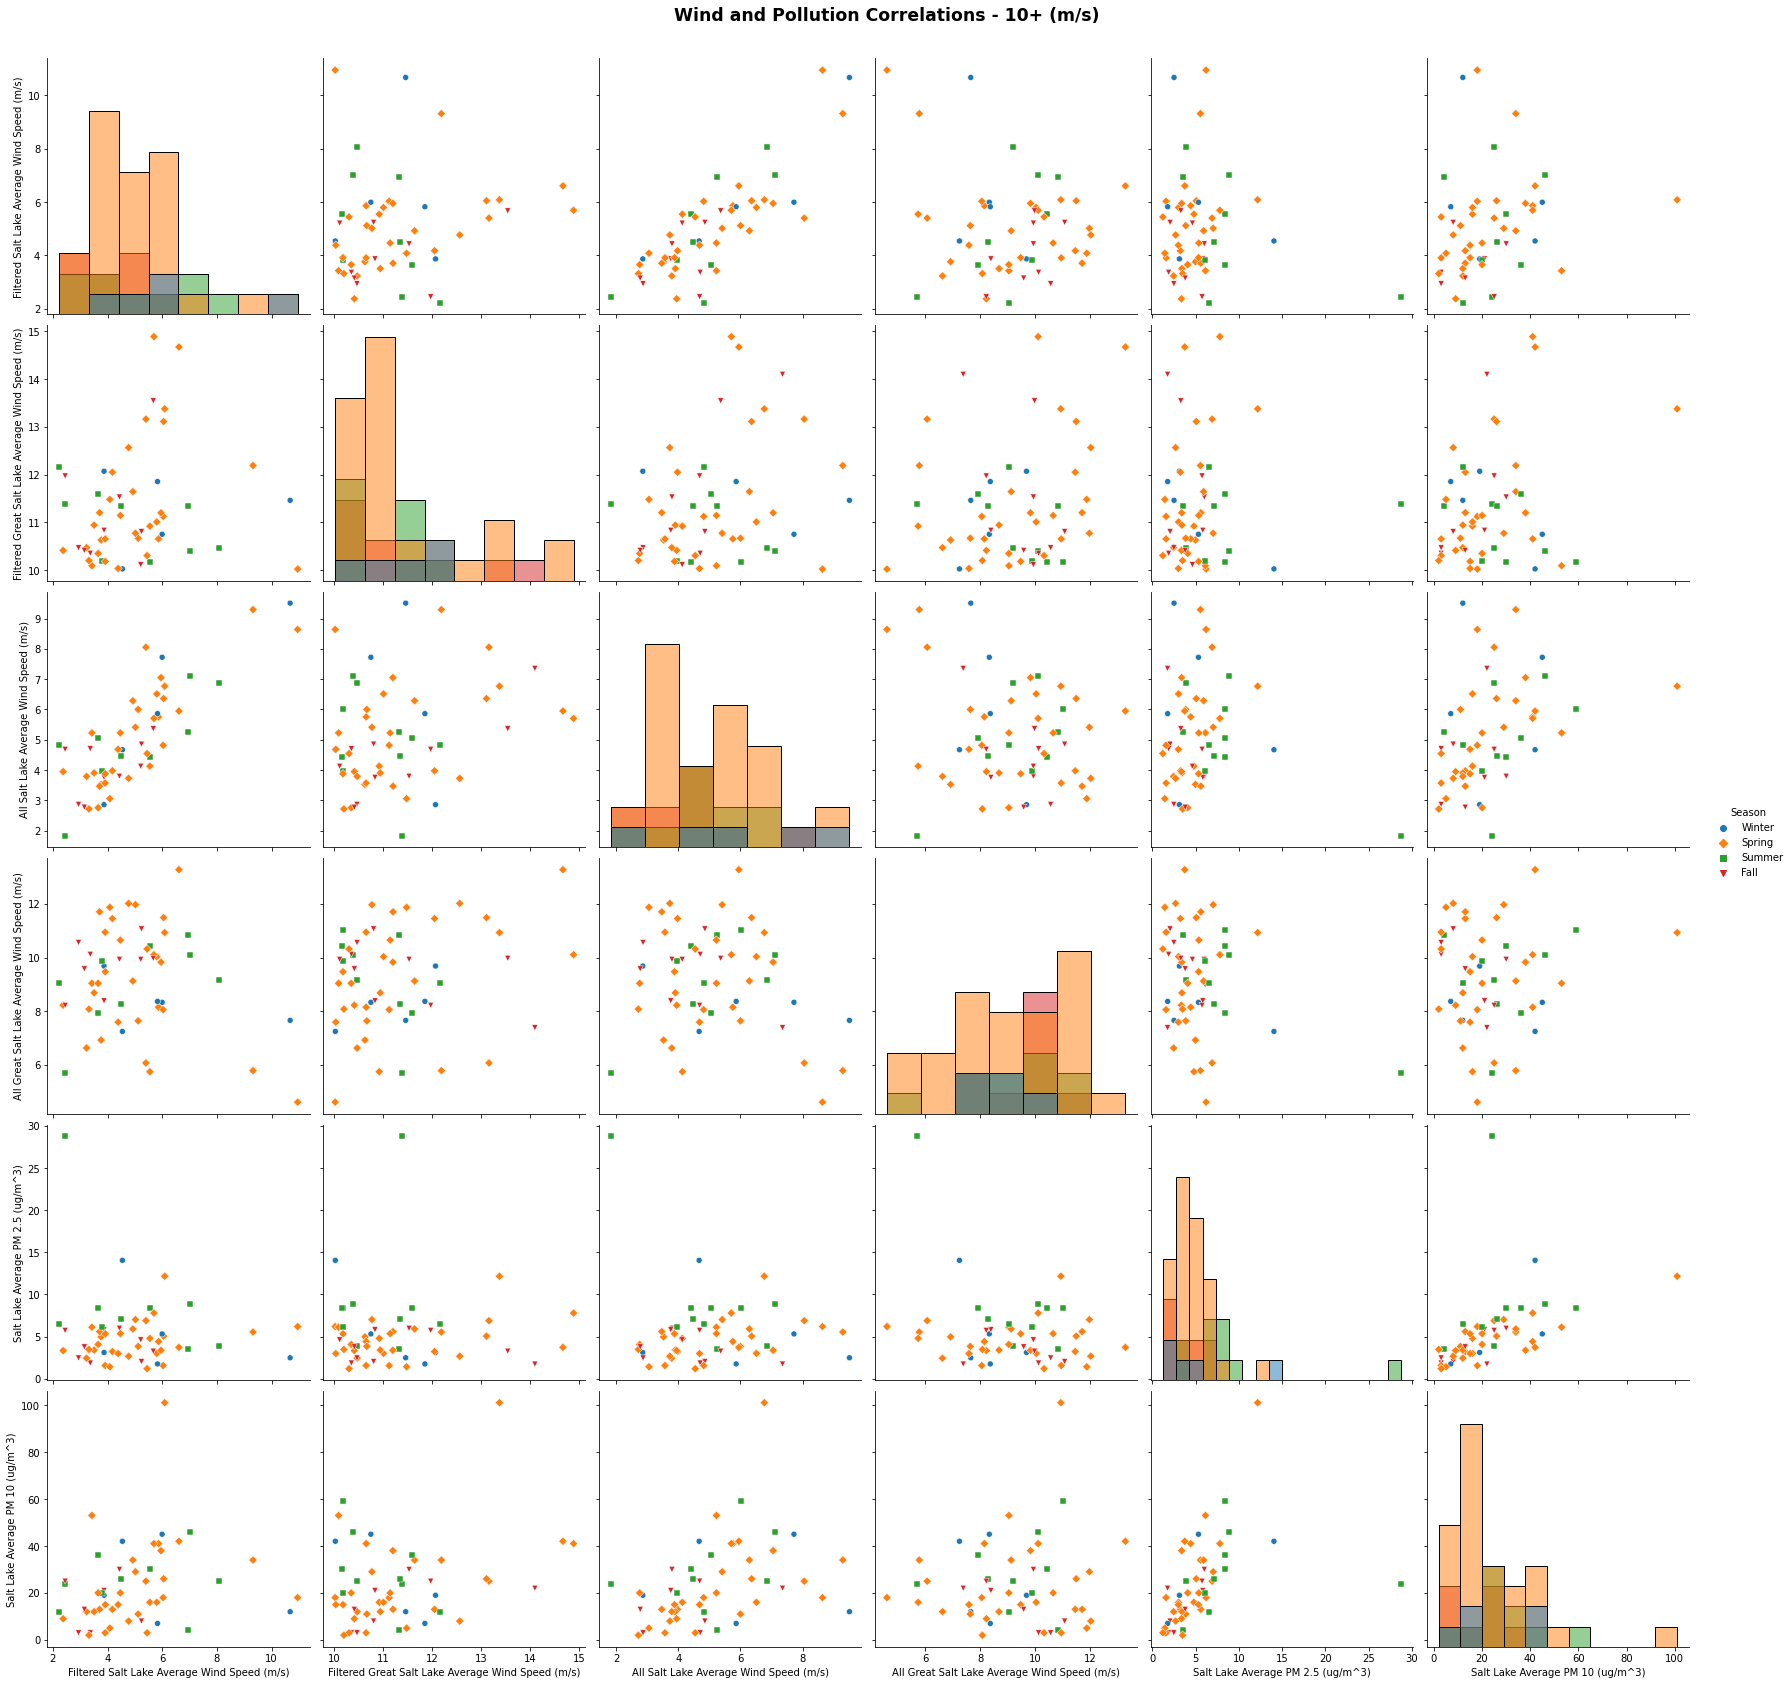

In [29]:
# Filter Great Salt Lake Wind Speeds
tmp = paired_data[(paired_data['Filtered Great Salt Lake Average Wind Speed (m/s)'] >= 10)]

highspeeds_plot = sns.pairplot(tmp,
                                hue = "Season",
                                markers=["o", "s", "D", "v"],
                                diag_kind = "hist",
                               hue_order = ["Winter", "Spring", "Summer", "Fall"],
                                height = 4)

#move overall title up
highspeeds_plot.fig.subplots_adjust(top = 0.95)

#add overall title
highspeeds_plot.fig.suptitle('Wind and Pollution Correlations - 10+ (m/s)', size = 'xx-large', weight = "bold");

# Find the correlations
correlations_highspeeds = tmp.corr(method = "spearman")
correlations_highspeeds


### Hypothesis Testing

Our null hypothesis, $H_0$, is that there is no relation between high wind speed around the Great Salt Lake and increased PM10 concentrations in the Salt Lake Valley

Where $\alpha = 0.01$

**SECTION:** Compute the Wilcoxon ranked-sum tests and Student's t-tests for each of the 8 relationships between a wind variable and a particulate matter variable.

In [30]:
# Define a function that subsets based on season and wind threshold and computes the Wilcoxon ranked-sum test/Student's t test
def statistical_analysis(data, season, wind_threshold):
    
    # Subsetting data
    tmp = data[(data['Season'] == season) &
               (data['Filtered Great Salt Lake Average Wind Speed (m/s)'] >= wind_threshold)]
    
    # WILCOXON RANKED SUM TEST
    
    # Comparing filtered Salt Lake averages to particulate matter
    slc_pm25 = stats.ranksums(tmp.iloc[:,1], tmp.iloc[:,5])[1]
    slc_pm10 = stats.ranksums(tmp.iloc[:,1], tmp.iloc[:,6])[1]
    
    # Comparing filtered Great Salt Lake averages to particulate matter
    gsl_pm25 = stats.ranksums(tmp.iloc[:,2], tmp.iloc[:,5])[1]
    gsl_pm10 = stats.ranksums(tmp.iloc[:,2], tmp.iloc[:,6])[1]
    
    # Comparing Great Salt Lake averages to particulate matter
    all_slc_pm25 = stats.ranksums(tmp.iloc[:,3], tmp.iloc[:,5])[1]
    all_slc_pm10 = stats.ranksums(tmp.iloc[:,3], tmp.iloc[:,6])[1]
    
    # Comparing Great Salt Lake averages to particulate matter
    all_gsl_pm25 = stats.ranksums(tmp.iloc[:,4], tmp.iloc[:,5])[1]
    all_gsl_pm10 = stats.ranksums(tmp.iloc[:,4], tmp.iloc[:,6])[1]
    
    
    wilcox_tests = {'Results': ' Wilcox Test',
                    'Salt Lake and PM 2.5': slc_pm25,
                    'Salt Lake and PM 10': slc_pm10,
                    'Great Salt Lake and PM 2.5': gsl_pm25,
                    'Great Salt Lake and PM 10': gsl_pm10,
                    'All Directions Salt Lake and PM 2.5': all_slc_pm25,
                    'All Directions Salt Lake and PM 10': all_slc_pm10,
                    'All Directions Great Salt Lake and PM 2.5': all_gsl_pm25,
                    'All Directions Great Salt Lake and PM 10': all_gsl_pm10,
                    'Wind Speed Lower Limit (m/s)': wind_threshold,
                    'Season': season}
    
    # STUDENTS T TEST
    
    # Comparing filtered Salt Lake averages to particulate matter
    slc_pm25 = stats.ttest_ind(tmp.iloc[:,1], tmp.iloc[:,5], nan_policy = "omit")[1]
    slc_pm10 = stats.ttest_ind(tmp.iloc[:,1], tmp.iloc[:,6], nan_policy = "omit")[1]
    
    # Comparing filtered Great Salt Lake averages to particulate matter
    gsl_pm25 = stats.ttest_ind(tmp.iloc[:,2], tmp.iloc[:,5], nan_policy = "omit")[1]
    gsl_pm10 = stats.ttest_ind(tmp.iloc[:,2], tmp.iloc[:,6], nan_policy = "omit")[1]
    
    # Comparing Great Salt Lake averages to particulate matter
    all_slc_pm25 = stats.ttest_ind(tmp.iloc[:,3], tmp.iloc[:,5], nan_policy = "omit")[1]
    all_slc_pm10 = stats.ttest_ind(tmp.iloc[:,3], tmp.iloc[:,6], nan_policy = "omit")[1]
    
    # Comparing Great Salt Lake averages to particulate matter
    all_gsl_pm25 = stats.ttest_ind(tmp.iloc[:,4], tmp.iloc[:,5], nan_policy = "omit")[1]
    all_gsl_pm10 = stats.ttest_ind(tmp.iloc[:,4], tmp.iloc[:,6], nan_policy = "omit")[1]
    
    t_tests = {'Results': ' Students t-test',
                    'Salt Lake and PM 2.5': slc_pm25,
                    'Salt Lake and PM 10': slc_pm10,
                    'Great Salt Lake and PM 2.5': gsl_pm25,
                    'Great Salt Lake and PM 10': gsl_pm10,
                    'All Directions Salt Lake and PM 2.5': all_slc_pm25,
                    'All Directions Salt Lake and PM 10': all_slc_pm10,
                    'All Directions Great Salt Lake and PM 2.5': all_gsl_pm25,
                    'All Directions Great Salt Lake and PM 10': all_gsl_pm10,
                    'Wind Speed Lower Limit (m/s)': wind_threshold,
                    'Season': season}
    
    return wilcox_tests, t_tests


**SECTION:** Create a dataframe of all the tests above using teh dictionaries created

In [31]:
# Apply function above to each season and for selected wind speed threshold
winter_tests = statistical_analysis(paired_data, "Winter", 10)
spring_tests = statistical_analysis(paired_data, "Spring", 10)
summer_tests = statistical_analysis(paired_data, "Summer", 10)
fall_tests = statistical_analysis(paired_data, "Fall", 10)

# Temporary dataframes for merging
tmp = pd.DataFrame(winter_tests)
tmp = pd.merge(tmp, pd.DataFrame(spring_tests), how = 'outer')
tmp = pd.merge(tmp, pd.DataFrame(summer_tests), how = 'outer')
tmp = pd.merge(tmp, pd.DataFrame(fall_tests), how = 'outer')

# Display the statistical summary
statistical_summary = tmp.sort_values('Season')
statistical_summary.round(5)

Results  Salt Lake and PM 2.5  Salt Lake and PM 10  \
6       Wilcox Test               0.49629              0.04125   
7   Students t-test               0.66843              0.00435   
2       Wilcox Test               0.16552              0.00000   
3   Students t-test               0.26554              0.00000   
4       Wilcox Test               0.11241              0.00815   
5   Students t-test               0.11992              0.00044   
0       Wilcox Test               0.25059              0.01629   
1   Students t-test               0.75384              0.04427   

   Great Salt Lake and PM 2.5  Great Salt Lake and PM 10  \
6                     0.00016                    0.17362   
7                     0.00000                    0.21753   
2                     0.00000                    0.00036   
3                     0.00000                    0.00167   
4                     0.00250                    0.00320   
5                     0.41132                    0.00298   
0                     0.11719                    0.17453   
1                     0.03298                    0.11607   

   All Directions Salt Lake and PM 2.5  All Directions Salt Lake and PM 10  \
6                              0.32575                             0.01017   
7                              0.33032                             0.00353   
2                              0.09249                             0.00000   
3                              0.20739                             0.00000   
4                              0.04125                             0.00150   
5                              0.10083                             0.00022   
0                              0.34721                             0.02828   
1                              0.76912                             0.04367   

   All Directions Great Salt Lake and PM 2.5  \
6                                    0.00016   
7                                    0.00000   
2                                    0.00000   
3                                    0.00000   
4                                    0.05878   
5                                    0.92033   
0                                    0.11719   
1                                    0.24075   

   All Directions Great Salt Lake and PM 10  Wind Speed Lower Limit (m/s)  \
6                                   0.11241                            10   
7                                   0.08002                            10   
2                                   0.00002                            10   
3                                   0.00026                            10   
4                                   0.00250                            10   
5                                   0.00146                            10   
0                                   0.11719                            10   
1                                   0.06453                            10   

   Season  
6    Fall  
7    Fall  
2  Spring  
3  Spring  
4  Summer  
5  Summer  
0  Winter  
1  Winter

### Seasonal Wind and Pollution Analysis Conclusions

If we were to judge to the relationships between wind and particulate matter based solely on p-values, we would be able to say we fail to reject the null hypothesis and conclude that there is a statistically significant relationship between high wind speed around the Great Salt Lake and increased PM10 concentrations in the Salt Lake Valley. However this would be irresponsible to claim without considering other factors.

Based on the correlation plots this is obviously a non-linear relationship. We additionally see improved and positive Spearman correlation coefficients for wind speeds in excess of 10 m/s (22 mph) and PM10 concentrations. The other wind speed categories do not see positive correlations between wind speed variables and particulate matter.

Our tests for statistical significance are the Wilcoxon Ranked-Sums Test and the Student's t-test. The Wilcoxon test is a non-parametric test where we do not assume ideal/normal data, whereas the Student's t-test is a parametric test and does assume ideal/normal data. We performed both to check for either case to identify if one test performed better than the other. The tests tend to agree so using either test provides the same results.

The issue we have with the results of these tests is how much validity does it actually add to our claims. Even without any restriction to wind speed, every single relationship is considered statistically signiciant. This makes sense, wind transports aerosols, so a statistically significant relationship between PM and wind makes sense. When we increase it to only high wind speeds we do see relationships failing to demonstrate significance. Additionally, when we consider *all* wind directions, what we are seeing is all movement and mixing. As we are trying to investigate if winds specifically from the direction from the Great Salt Lake in combination with high wind speed contribute to dust, we should focus more on the filtered wind direction relationships.

Another factor to consider is that the wind speeds in Salt Lake have a relationship with those from the Great Salt Lake at a physical level. Wind in Salt Lake could be a result of the Great Salt Lake. The reason we computed our p-values for wind speeds at the Great Salt Lake only, was to select days where dust was likely prevalent. To identify which relationships actually add validity to our claim we now consider only the filtered data from Salt Lake (the first two columns).

For this category we see the relationship between Salt Lake and PM2.5 no longer produces any p-values below $\alpha$ regardless season or testing method. For Salt Lake and PM10, the relationships are significant at our level of confidence with the exception of days during the winter. The strongest statistically signficant relationship is wind speeds in excess of 10 m/s in the Salt Lake Valley and PM10.


### Summary

Our overall research question was to identify if there is a statistically significant correlation between high wind speeds originating from the Great Salt Lake/Great Basin and particulate matter throughout the Salt Lake Valley.

We have found that there does exist a relationship and there is statistical evidence supporting our hypothesis that there is a statistically significant correlation between high wind speeds originating from the Great Salt Lake/Great Basin and particulate matter throughout the Salt Lake Valley.

However, our approach of only using wind data to derive this relationship is primitive and to confirm our results we would need to classify differences between wildfire smoke and dust, and perform more analysis on our observations beyond the scope of this project.


## Visualization

**SECTION:** Wind Roses

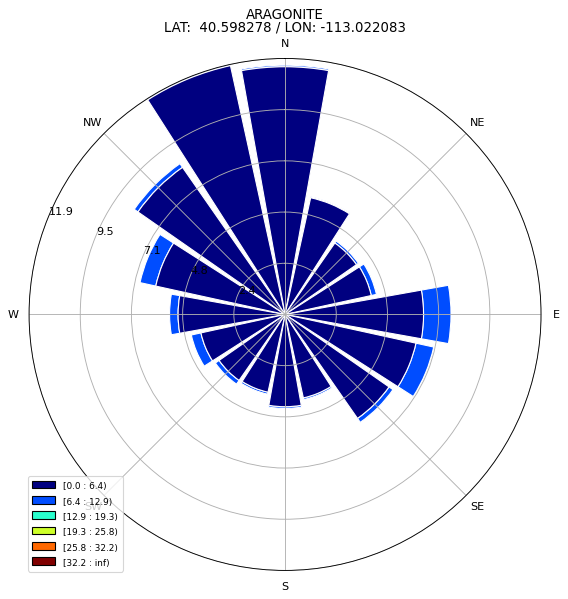

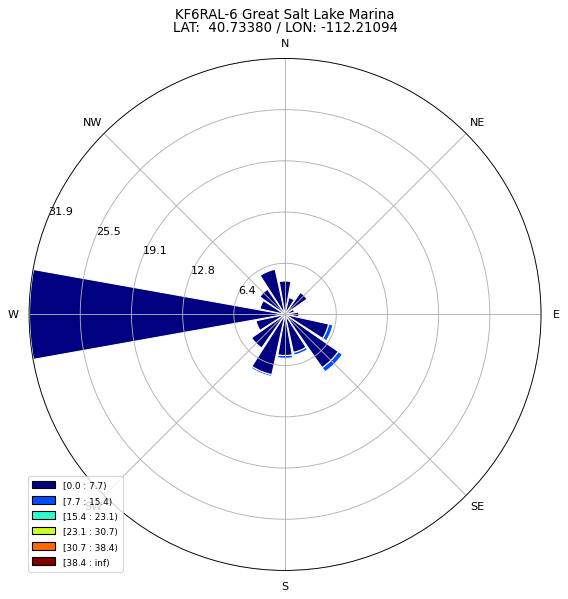

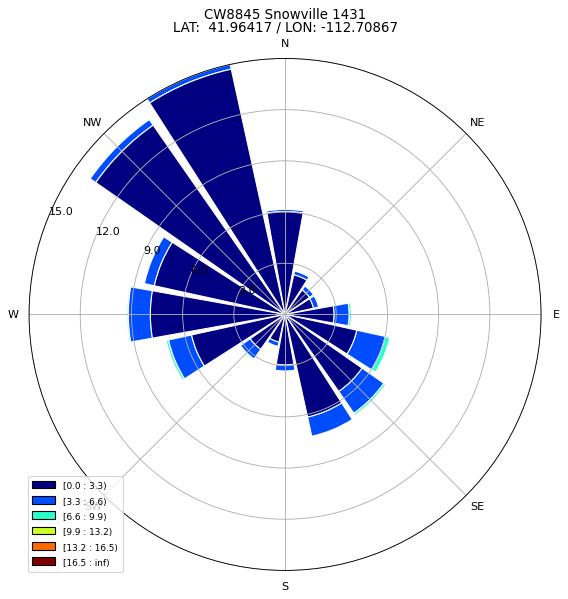

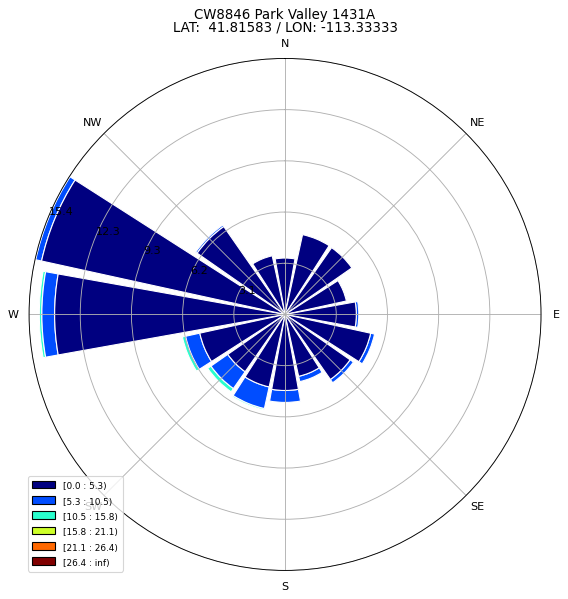

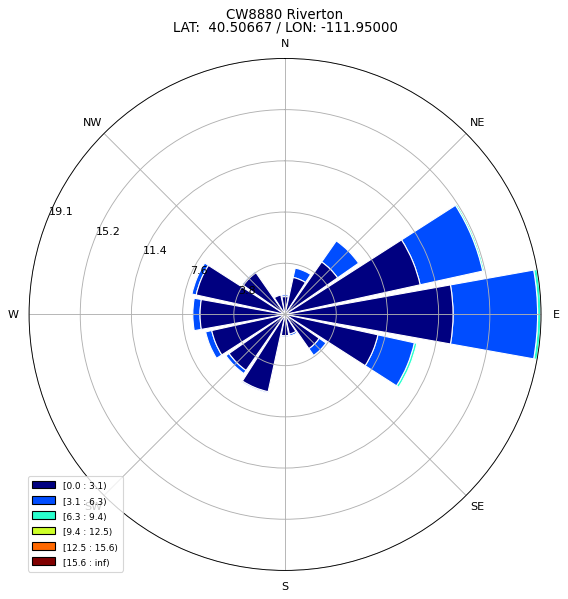

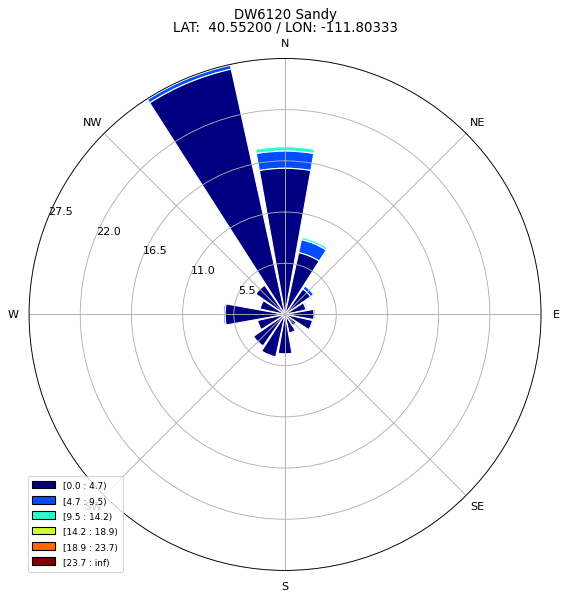

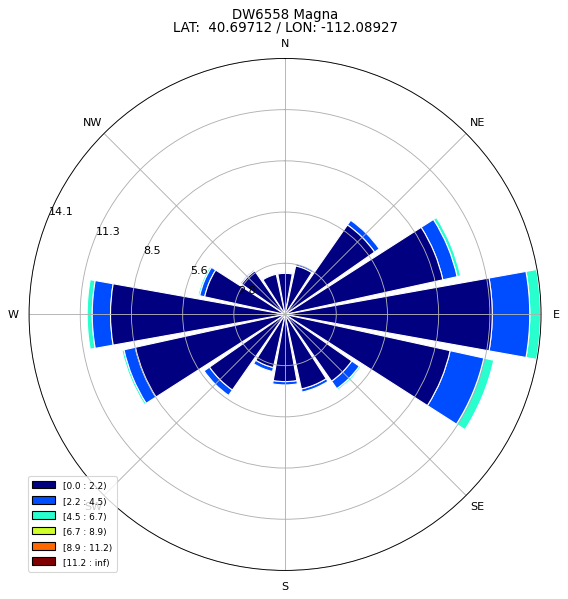

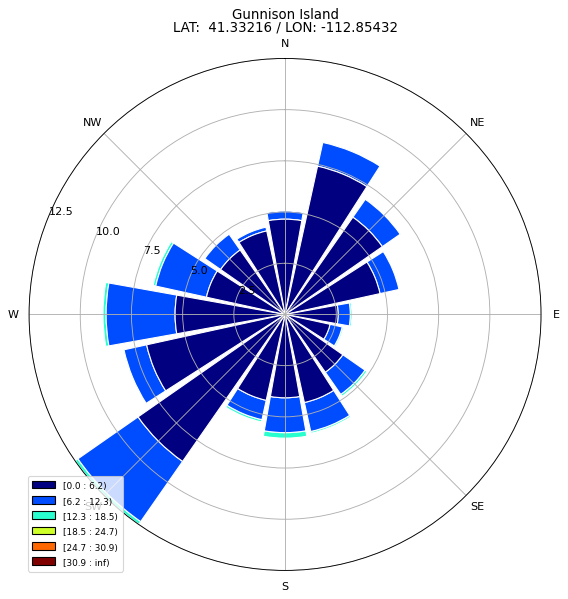

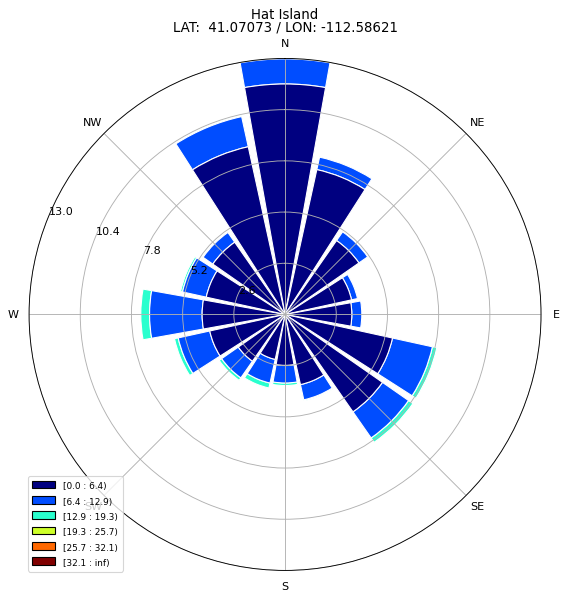

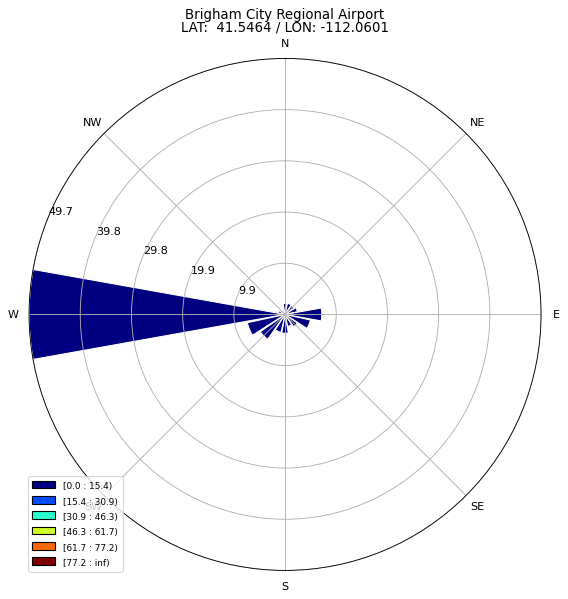

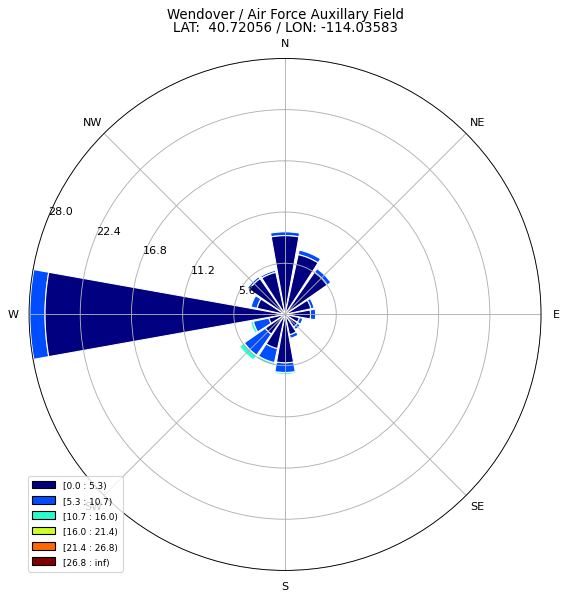

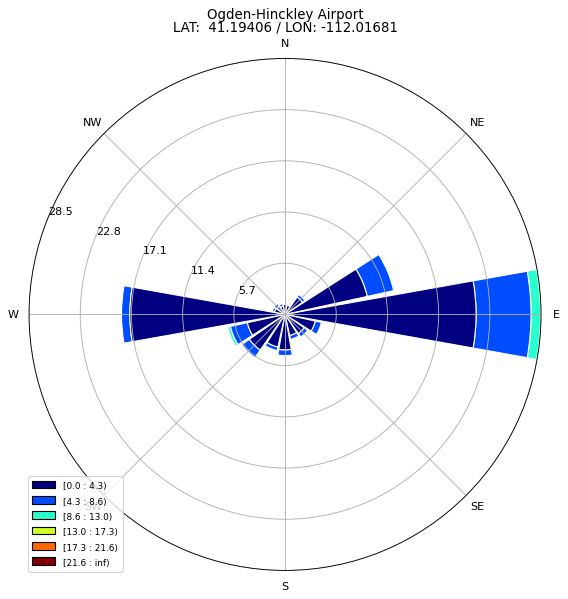

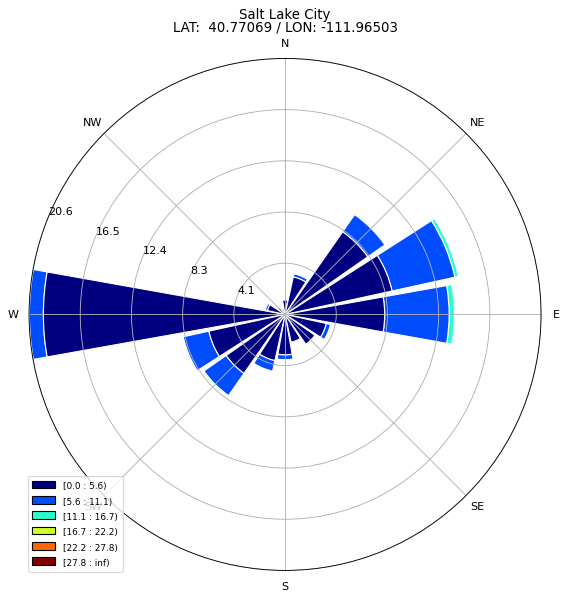

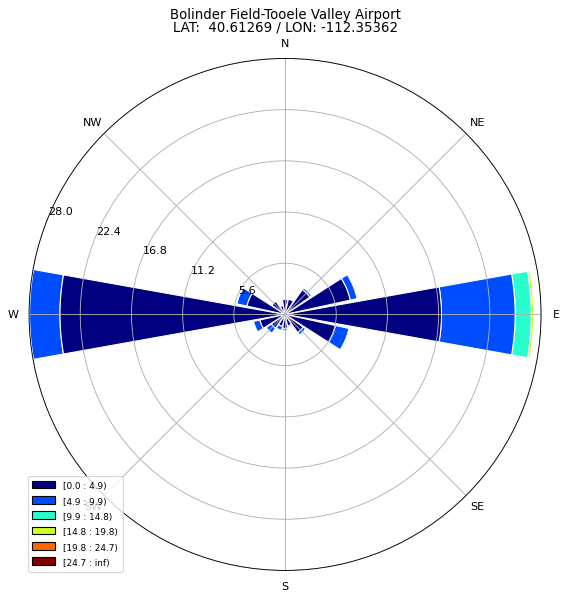

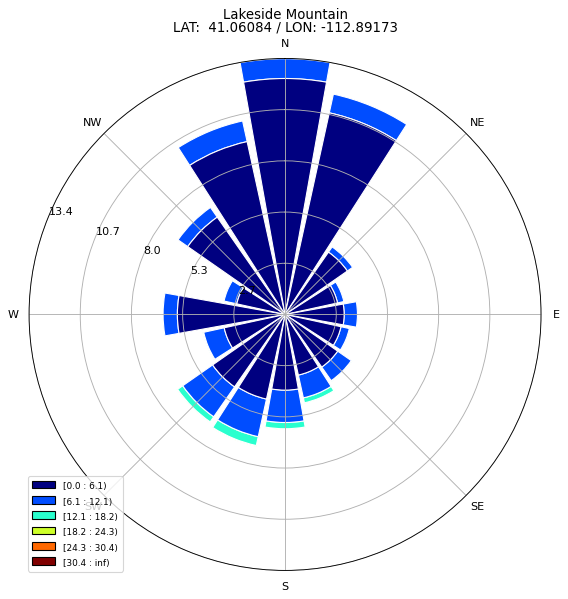

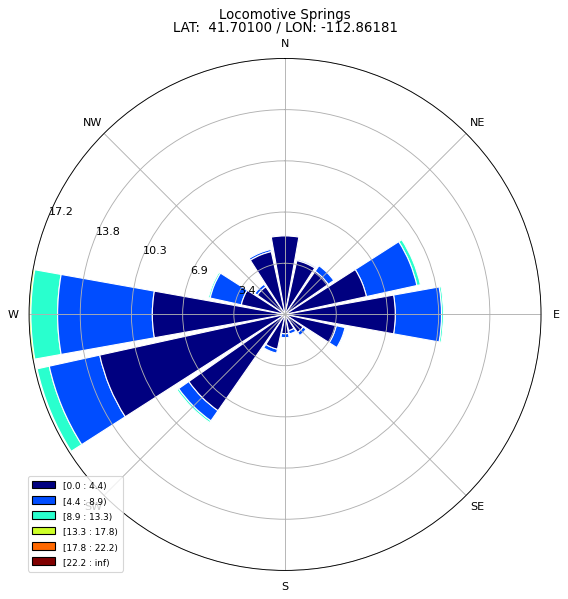

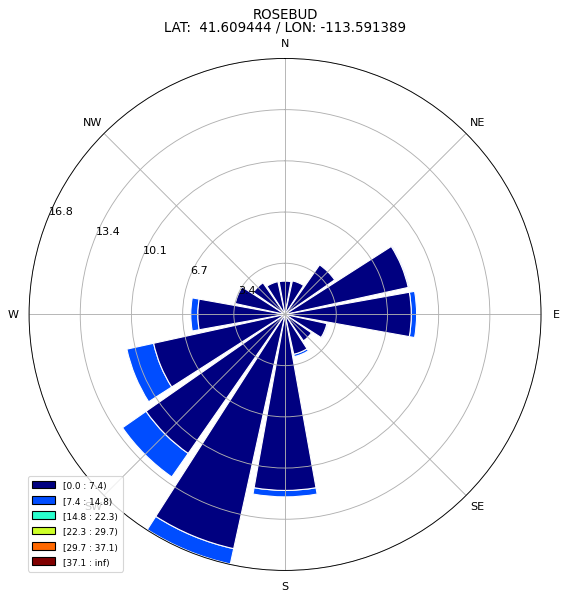

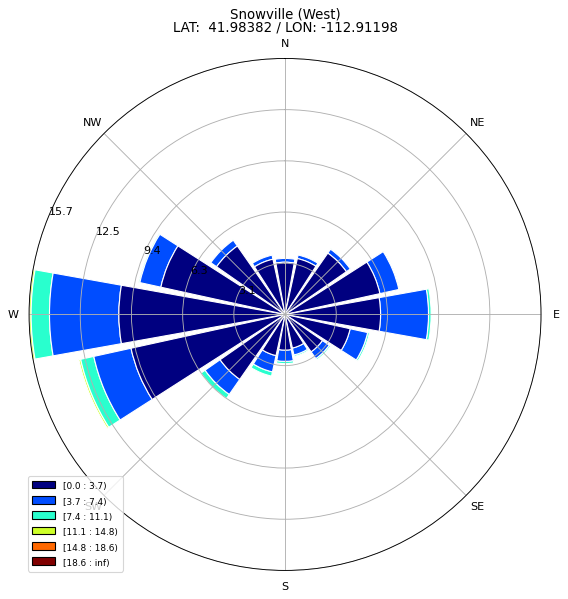

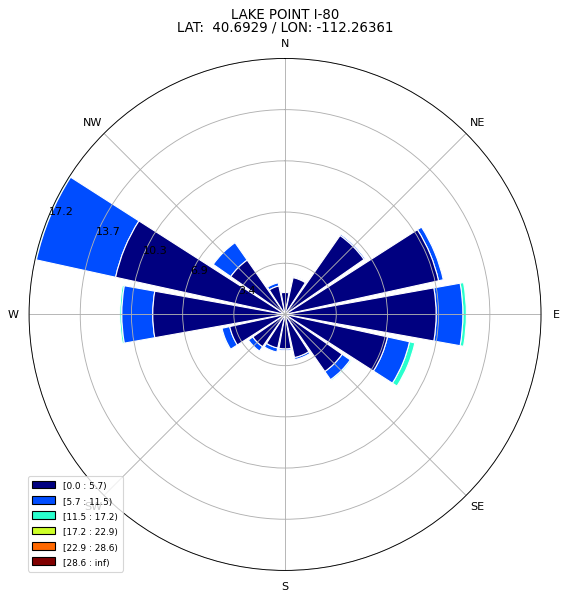

In [32]:
station_names = data_met['Station Name'].unique()

# Create a for loop to loop through each station name and create a wind rose plot per site
for i in (range(0, len(station_names), 1)):

    tmp = data_met[data_met['Station Name'] == station_names[i]]
    
    ax = WindroseAxes.from_ax()
    ax.bar(direction = tmp['Wind Direction (deg)'],
           var = tmp['Wind Speed (m/s)'],
           normed = True,
           opening = 0.9,
           edgecolor = 'white')

    ax.set_legend()
    
    # Title of the plot is the statin name
    plt.suptitle(tmp['Station Name'][0]);
    
    # Additionally include the latitude and longitude of each
    plt.title('LAT: '+tmp['Latitude'][0]+ ' / LON: '+tmp['Longitude'][0]);
    
    # Add cardinal directions to each plot rather than degrees
    ax.set_xticklabels(['N', 'NW',  'W', 'SW', 'S', 'SE','E', 'NE']);
    
    # Set north to be theta = 0 as it should be for wind roses
    ax.set_theta_zero_location('N')



**SECTION:** Wind Roses

## References

### American Meteorological Society Format

Gardiner, J., 2020: Salt Lake City ranked as one of the worst cities for air quality in the world, Utah doctor weighs in. ABC4 Utah. https://www.abc4.com/news/salt-lake-city-ranked-as-one-of-the-worst-cities-for-air-quality-in-the-world-utah-doctor-weighs-in/ (Accessed March 26, 2021). 

Mahowald, N., S. Albani, J. F. Kok, S. Engelstaeder, R. Scanza, D. S. Ward, and M. G. Flanner, 2014: The size distribution of desert dust aerosols and its impact on the Earth system. Aeolian Research, 15, 53–71, doi:10.1016/j.aeolia.2013.09.002. 

Skiles, S. M. K., T. H. Painter, J. S. Deems, A. C. Bryant, and C. C. Landry, 2012: Dust radiative forcing in snow of the Upper Colorado River Basin: 2. Interannual variability in radiative forcing and snowmelt rates. Water Resources Research, 48, doi:10.1029/2012wr011986.

Goodman, M. M., G. T. Carling, D. P. Fernandez, K. A. Rey, C. A. Hale, B. R. Bickmore, S. T. Nelson, and J. S. Munroe, 2019: Trace element chemistry of atmospheric deposition along the Wasatch Front (Utah, USA) reflects regional playa dust and local urban aerosols. Chemical Geology, 530, 119317, doi:10.1016/j.chemgeo.2019.119317.
EPA, n.d.; Research on Health Effects from Air Pollution, United States Environmental Protection Agency. Accessed 26 March 2021, https://www.epa.gov/air-research/research-health-effects-air-pollution#long-term-short-term.

Utah Asthma Program, n.d.; Our Program, Utah Asthma Program, Bureau of Health Promotion, Utah Department of Health. Accessed 26 March 2021, http://www.health.utah.gov/asthma/aboutus.html.
